In [ ]:
# General modules
import sys
import os
import session_info
import warnings
from pyprojroot.here import here
import glob
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
from IPython.display import display

from tqdm import tqdm
# Specific modules
import scanpy as sc
import anndata as ad
import scienceplots
import seaborn as sns

from upsetplot import UpSet, from_indicators, plot


# Setting some parameters
warnings.filterwarnings("ignore")
# sys.path.insert(1, str(here('bin')))

# Import functions
# from customPythonFunctions import qc_gex_projectlibrary, qc_gene_expression_per_study

plt.style.use(['science','nature','no-latex'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)


# Specific modules
import requests
import re
import scanpy as sc
import anndata as ad

sys.path.insert(1, str(here('bin')))

# Setting some parameters
warnings.filterwarnings("ignore")

# from customPythonFunctions import generatePatientBarcode

pd.options.display.max_columns=300
pd.options.display.max_rows=1000

overwriteFigure = True

In [ ]:
print("Main directory path: {}".format(here()))

**Loading HUGO gene information**

In [ ]:
# Download the last gene set catalog
extHUGO_DF_fn = here('external_reference_data/hgnc_complete_set_2024-02-01_pandas.csv')
extHUGO_DF = pd.read_csv(extHUGO_DF_fn, sep= '\t')

len(extHUGO_DF["symbol"].unique())

In [ ]:
extHUGO_DF.head()

In [5]:
extHUGO_DF_n = extHUGO_DF.drop(columns=["alias_or_prev"]).drop_duplicates("ensembl_gene_id").copy()
len(extHUGO_DF_n["symbol"].unique())

41204

In [6]:
extHUGO_DF_n.head()

,hgnc_id,symbol,ensembl_gene_id,locus_group
0,HGNC:5,A1BG,ENSG00000121410,protein-coding gene
1,HGNC:37133,A1BG-AS1,ENSG00000268895,non-coding RNA
5,HGNC:24086,A1CF,ENSG00000148584,protein-coding gene
10,HGNC:7,A2M,ENSG00000175899,protein-coding gene
13,HGNC:27057,A2M-AS1,ENSG00000245105,non-coding RNA


# Assessing effect of different Genome Reference / behaviour used by CellRanger

CellRanger version: v6.1.1


* BRCA37 --> HumanGenomeRef: GRCh37-2020-A; GENCODE Ensembl 87
* BRCA38v93 --> HumanGenomeRef: GRCh38; Ensembl93
* **BRCA38v98** --> HumanGenomeRef: GRCh38-2020-A; Ensembl98
* BRCA38v98 --> HumanGenomeRef: GRCh38-2020-A; Ensembl98 --> Including INTRONS

In [7]:
# Load datasets
adata_BRCA37 = sc.read_10x_h5(here('01_data_processing/datasets/inhouse_data_unprocessed/BRCA/SERRAVIO_05_06/jobs/i33pzh12_shyncra2_hg19/i33pzh12_shyncra2_hg19/outs/per_sample_outs/i33pzh12_shyncra2_hg19/count/sample_feature_bc_matrix.h5'))
adata_BRCA37

AnnData object with n_obs × n_vars = 6091 × 32738
    var: 'gene_ids', 'feature_types', 'genome'

In [8]:
# Load datasets
adata_BRCA38v93 = sc.read_10x_h5(here('01_data_processing/datasets/inhouse_data_unprocessed/BRCA/SERRAVIO_05_06/jobs/i33pzh12_shyncra2_hg38v93/i33pzh12_shyncra2_hg38v93/outs/per_sample_outs/i33pzh12_shyncra2_hg38v93/count/sample_feature_bc_matrix.h5'))
adata_BRCA38v93

AnnData object with n_obs × n_vars = 6070 × 33538
    var: 'gene_ids', 'feature_types', 'genome'

In [9]:
# Load datasets
adata_BRCA38v98 = sc.read_10x_h5(here('01_data_processing/datasets/inhouse_data_unprocessed/BRCA/SERRAVIO_05_06/jobs/i33pzh12_shyncra2/i33pzh12_shyncra2/outs/per_sample_outs/i33pzh12_shyncra2/count/sample_feature_bc_matrix.h5'))
adata_BRCA38v98

AnnData object with n_obs × n_vars = 6107 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [10]:
# Load datasets
adata_BRCA38v98introns = sc.read_10x_h5(here('01_data_processing/datasets/inhouse_data_unprocessed/BRCA/SERRAVIO_05_06/jobs/i33pzh12_shyncra2_introns/i33pzh12_shyncra2_introns/outs/per_sample_outs/i33pzh12_shyncra2_introns/count/sample_feature_bc_matrix.h5'))
adata_BRCA38v98introns

AnnData object with n_obs × n_vars = 6267 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [11]:
# Working only with common cells
adata_BRCA37_cells = adata_BRCA37.obs_names
adata_BRCA38v93_cells = adata_BRCA38v93.obs_names
adata_BRCA38v98_cells = adata_BRCA38v98.obs_names
adata_BRCA38v98introns_cells = adata_BRCA38v98introns.obs_names

# Find common genes across all lists
common_cells = set(adata_BRCA37_cells).intersection(adata_BRCA38v93_cells, adata_BRCA38v98_cells, adata_BRCA38v98introns_cells)
# Convert the result to a list if needed
common_cells = list(common_cells)
print(len(common_cells))

# Subsetting
adata_BRCA37 = adata_BRCA37[adata_BRCA37.obs_names.isin(common_cells)].copy()
adata_BRCA38v93 = adata_BRCA38v93[adata_BRCA38v93.obs_names.isin(common_cells)].copy()
adata_BRCA38v98 = adata_BRCA38v98[adata_BRCA38v98.obs_names.isin(common_cells)].copy()
adata_BRCA38v98introns = adata_BRCA38v98introns[adata_BRCA38v98introns.obs_names.isin(common_cells)].copy()

print(adata_BRCA37)
print(adata_BRCA38v93)
print(adata_BRCA38v98)
print(adata_BRCA38v98introns)

6026
AnnData object with n_obs × n_vars = 6026 × 32738
    var: 'gene_ids', 'feature_types', 'genome'
AnnData object with n_obs × n_vars = 6026 × 33538
    var: 'gene_ids', 'feature_types', 'genome'
AnnData object with n_obs × n_vars = 6026 × 36601
    var: 'gene_ids', 'feature_types', 'genome'
AnnData object with n_obs × n_vars = 6026 × 36601
    var: 'gene_ids', 'feature_types', 'genome'


## Considering genes expressed without restrictions

In [12]:
# Step 1: Identify genes with expression greater than 0 in at least one cell
# Step 2: Subset the count matrix based on identified genes

adata_BRCA37_genes = adata_BRCA37.X.sum(axis=0) > 0
adata_BRCA37_genes = list(adata_BRCA37[:, adata_BRCA37_genes.A1].var.gene_ids)
print(len(adata_BRCA37_genes))

adata_BRCA38v93_genes = adata_BRCA38v93.X.sum(axis=0) > 0
adata_BRCA38v93_genes = list(adata_BRCA38v93[:, adata_BRCA38v93_genes.A1].var.gene_ids)
print(len(adata_BRCA38v93_genes))

adata_BRCA38v98_genes = adata_BRCA38v98.X.sum(axis=0) > 0
adata_BRCA38v98_genes = list(adata_BRCA38v98[:, adata_BRCA38v98_genes.A1].var.gene_ids)
print(len(adata_BRCA38v98_genes))

adata_BRCA38v98introns_genes = adata_BRCA38v98introns.X.sum(axis=0) > 0
adata_BRCA38v98introns_genes = list(adata_BRCA38v98introns[:, adata_BRCA38v98introns_genes.A1].var.gene_ids)
print(len(adata_BRCA38v98introns_genes))

# Preserve gene name -- nonHUGO
adata_BRCA37.var["gene_names"] = adata_BRCA37.var_names
adata_BRCA38v93.var["gene_names"] = adata_BRCA38v93.var_names
adata_BRCA38v98.var["gene_names"] = adata_BRCA38v98.var_names
adata_BRCA38v98introns.var["gene_names"] = adata_BRCA38v98introns.var_names

# Setting index back
adata_BRCA37.var_names = adata_BRCA37.var.gene_ids
adata_BRCA38v93.var_names = adata_BRCA38v93.var.gene_ids
adata_BRCA38v98.var_names = adata_BRCA38v98.var.gene_ids
adata_BRCA38v98introns.var_names = adata_BRCA38v98introns.var.gene_ids

20050
20421
21989
25107


### Gene distribution

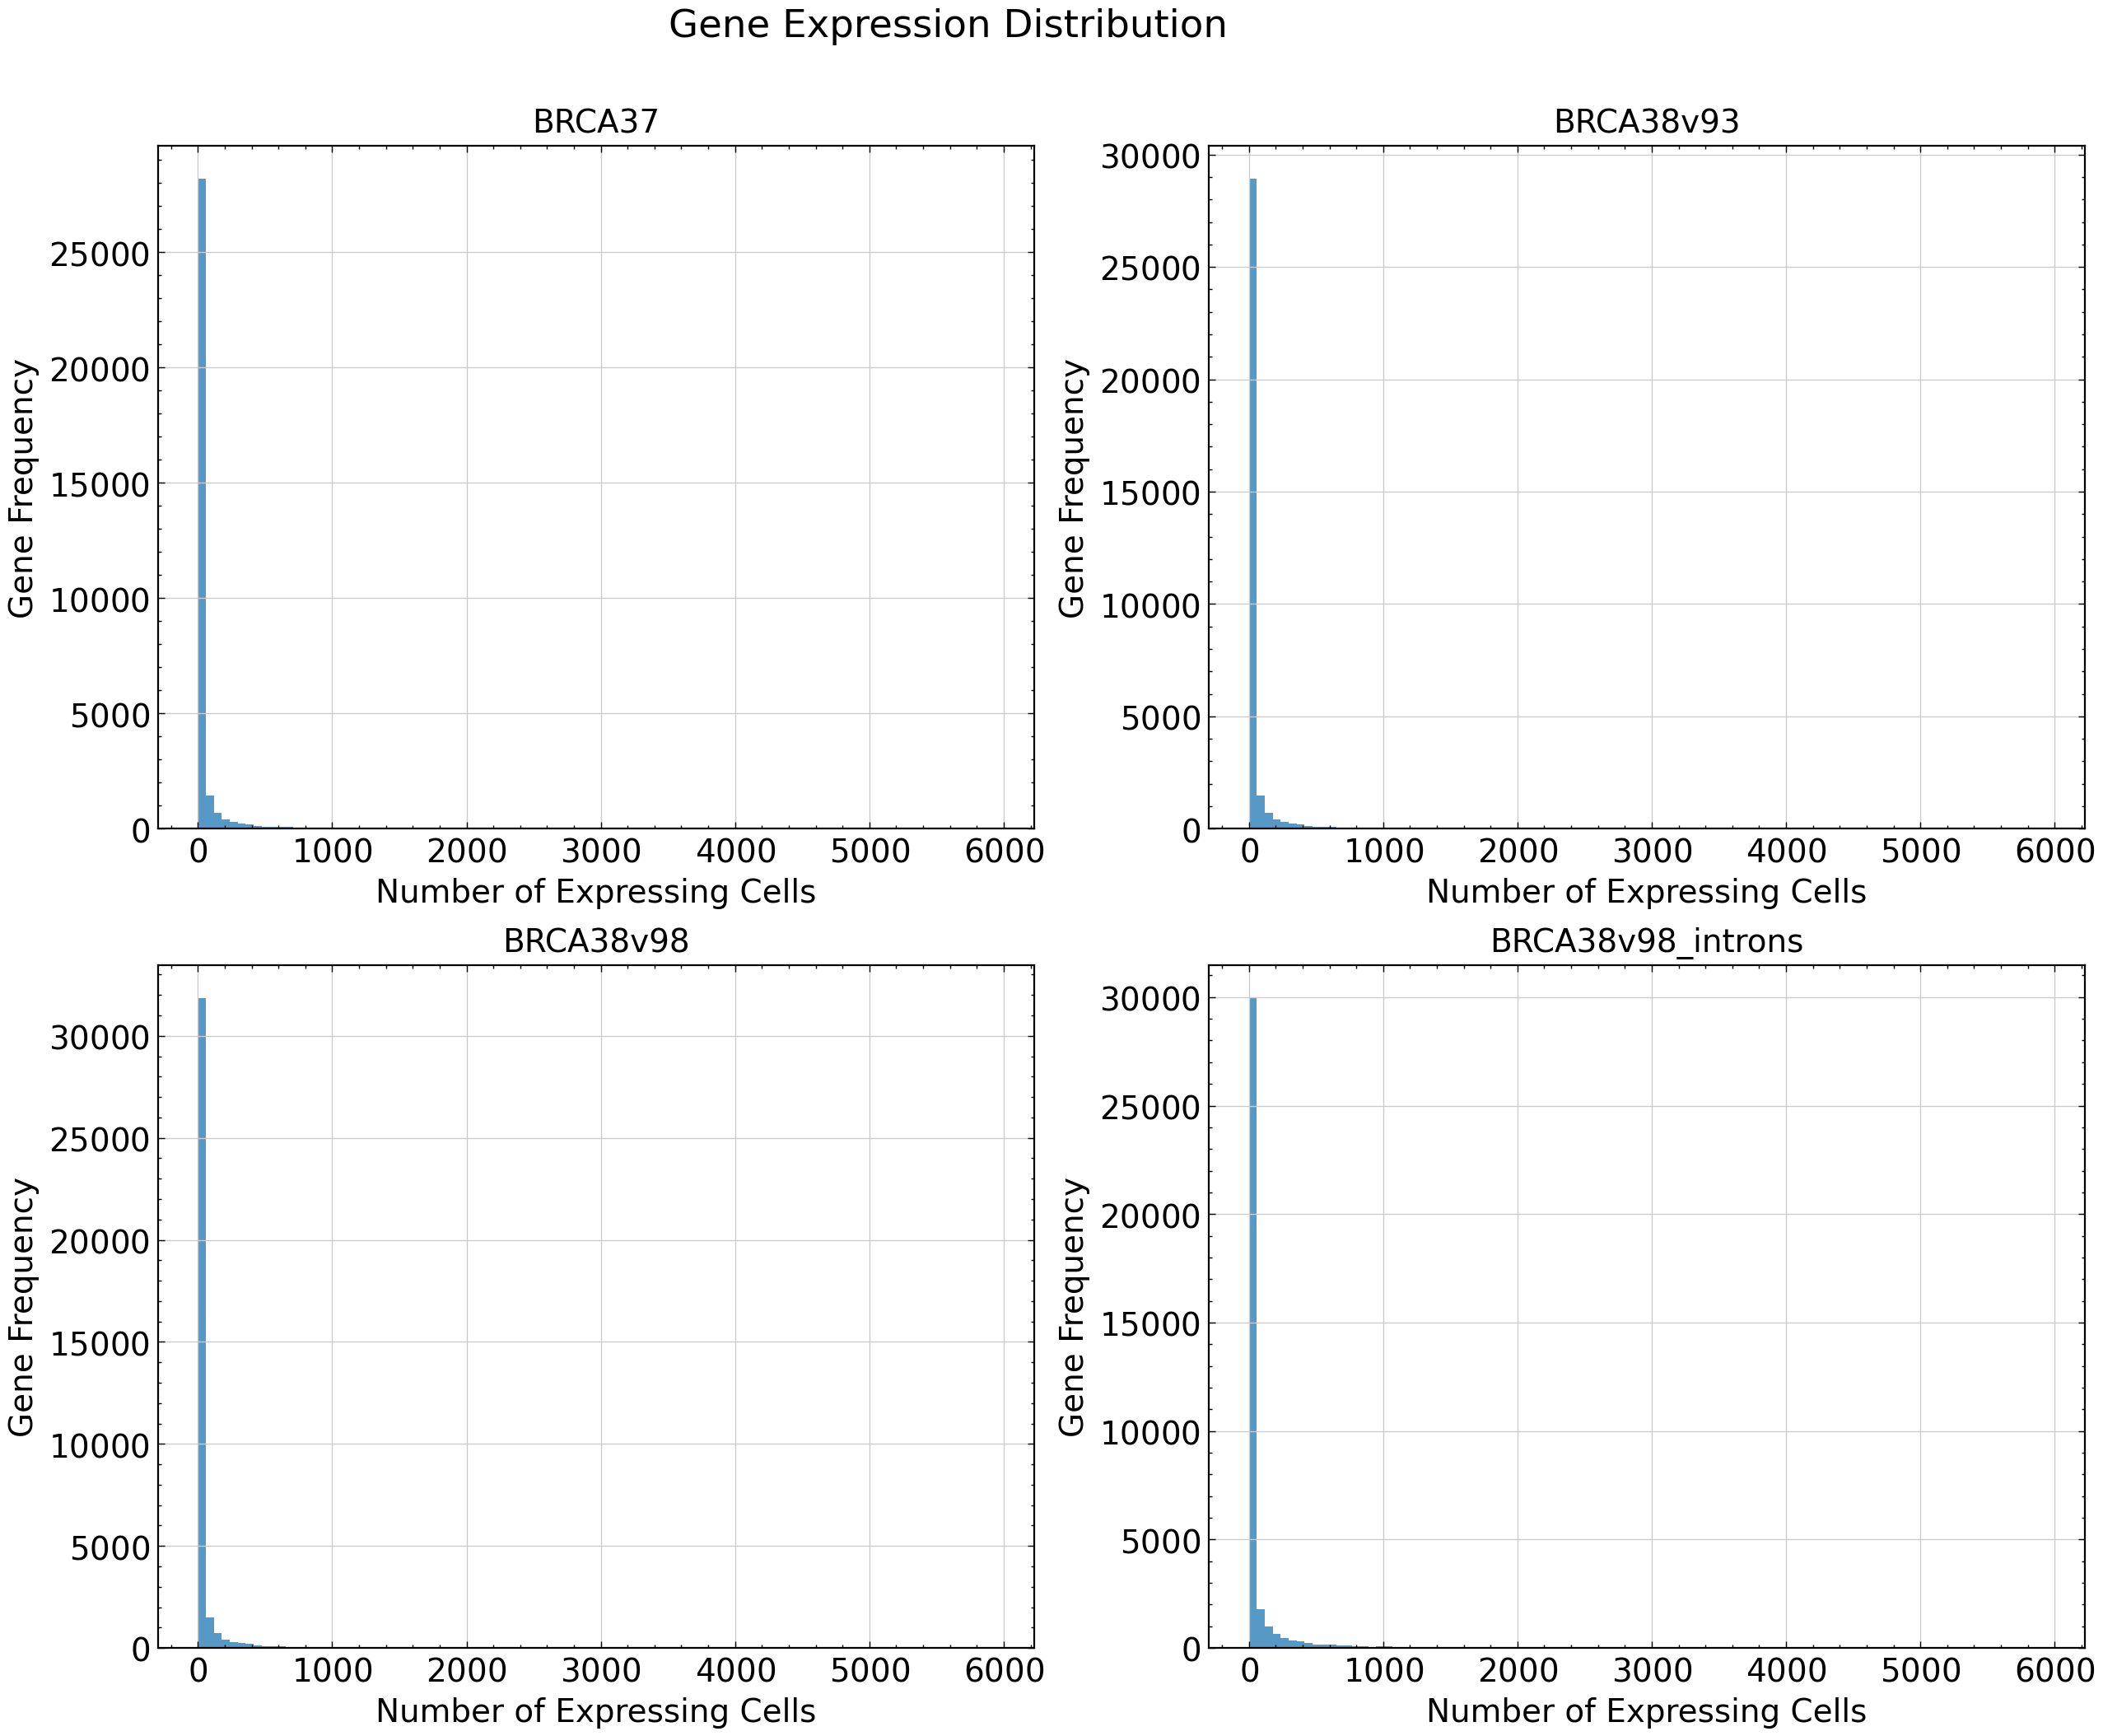

In [13]:
# Getting data ready
n_cells_BRCA37 = np.sum(adata_BRCA37.X > 1, axis=0)
n_cells_df_BRCA37 = np.ravel(n_cells_BRCA37)

n_cells_BRCA38v93 = np.sum(adata_BRCA38v93.X > 1, axis=0)
n_cells_df_BRCA38v93 = np.ravel(n_cells_BRCA38v93)

n_cells_BRCA38v98 = np.sum(adata_BRCA38v98.X > 1, axis=0)
n_cells_df_BRCA38v98 = np.ravel(n_cells_BRCA38v98)

n_cells_BRCA38v98introns = np.sum(adata_BRCA38v98introns.X > 1, axis=0)
n_cells_df_BRCA38v98introns = np.ravel(n_cells_BRCA38v98introns)


# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Gene Expression Distribution")

axs[0, 0].hist(n_cells_df_BRCA37, bins=100, alpha=0.75)
axs[0, 0].set_xlabel('Number of Expressing Cells')
axs[0, 0].set_ylabel('Gene Frequency')
axs[0, 0].set_title("BRCA37")

axs[0, 1].hist(n_cells_df_BRCA38v93, bins=100, alpha=0.75)
axs[0, 1].set_xlabel('Number of Expressing Cells')
axs[0, 1].set_ylabel('Gene Frequency')
axs[0, 1].set_title("BRCA38v93")

axs[1, 0].hist(n_cells_df_BRCA38v98, bins=100, alpha=0.75)
axs[1, 0].set_xlabel('Number of Expressing Cells')
axs[1, 0].set_ylabel('Gene Frequency')
axs[1, 0].set_title("BRCA38v98")

axs[1, 1].hist(n_cells_df_BRCA38v98introns, bins=100, alpha=0.75)
axs[1, 1].set_xlabel('Number of Expressing Cells')
axs[1, 1].set_ylabel('Gene Frequency')
axs[1, 1].set_title("BRCA38v98_introns")

plt.show()

### Comparison of gene overlapping

In [14]:
# Create sets of UNIQUE gene names
adata_BRCA37_genes = set(adata_BRCA37_genes)
adata_BRCA38v93_genes = set(adata_BRCA38v93_genes)
adata_BRCA38v98_genes = set(adata_BRCA38v98_genes)
adata_BRCA38v98introns_genes = set(adata_BRCA38v98introns_genes)


# Get the union of gene names
all_genes = adata_BRCA37_genes.union(adata_BRCA38v93_genes, adata_BRCA38v98_genes, adata_BRCA38v98introns_genes)

# Create a DataFrame with default values as False
genes_df = pd.DataFrame(index=list(all_genes), columns=['BRCA37', 'BRCA38v93', 'BRCA38v98', 'BRCA38v98introns'], data=False)

# Update values based on the presence of genes in the BRCA37 and BRCA38 sets
genes_df['BRCA37'] = genes_df.index.isin(adata_BRCA37_genes)
genes_df['BRCA38v93'] = genes_df.index.isin(adata_BRCA38v93_genes)
genes_df['BRCA38v98'] = genes_df.index.isin(adata_BRCA38v98_genes)
genes_df['BRCA38v98introns'] = genes_df.index.isin(adata_BRCA38v98introns_genes)
genes_df['genes'] = genes_df.index
genes_df.reset_index(drop=True, inplace=True)
genes_df = genes_df.set_index('genes')
genes_df = genes_df.sort_values(by='genes')
genes_df.head()

,BRCA37,BRCA38v93,BRCA38v98,BRCA38v98introns
genes,,,,
ENSG00000000003,True,True,True,True
ENSG00000000419,True,True,True,True
ENSG00000000457,True,True,True,True
ENSG00000000460,True,True,True,True
ENSG00000000938,True,True,True,True


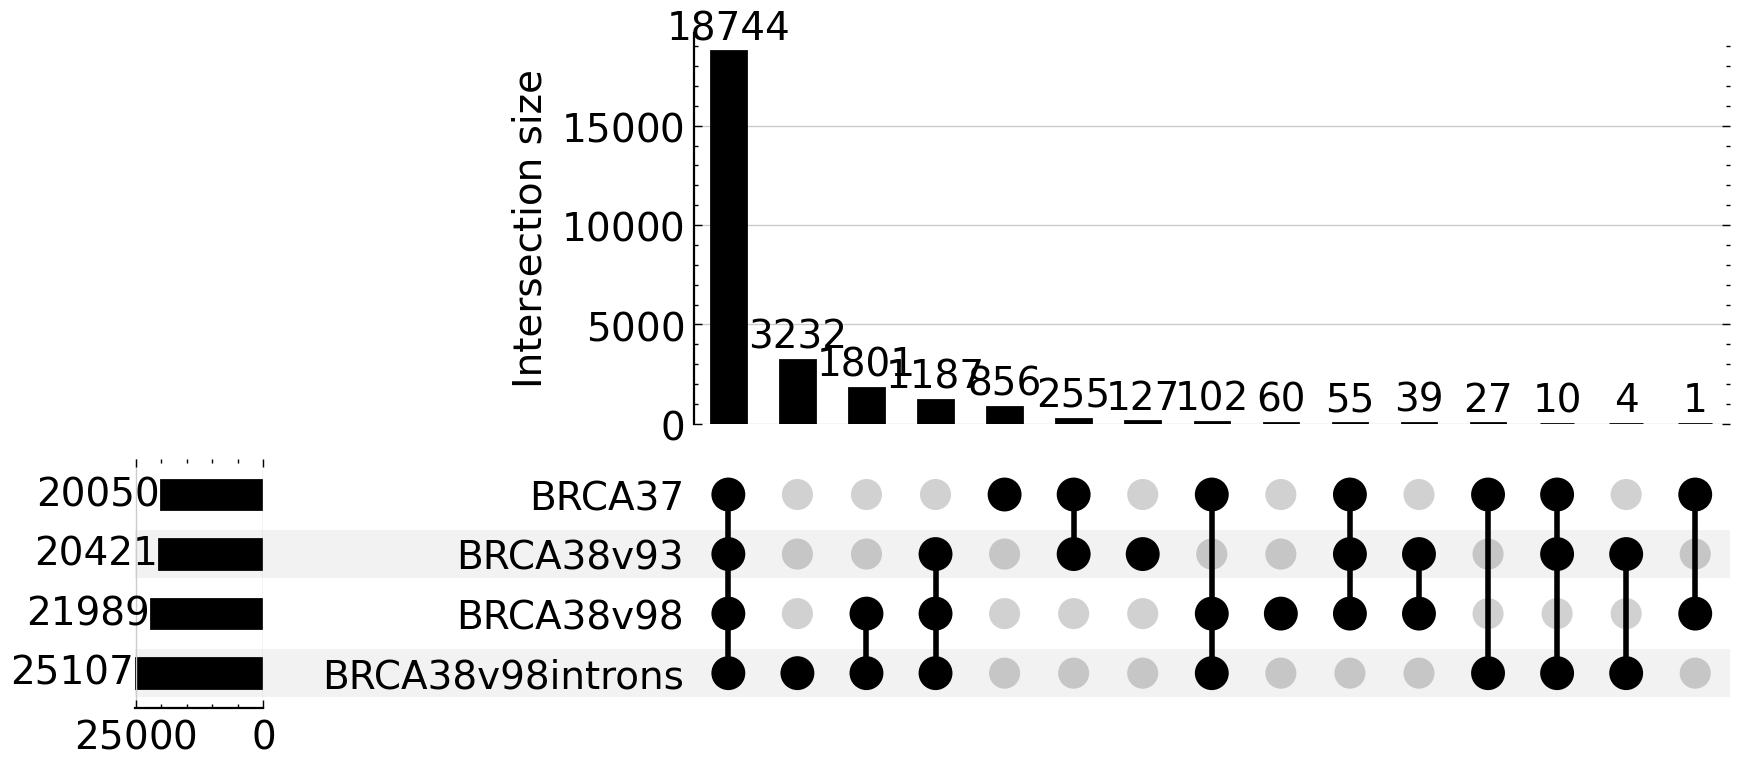

In [15]:
# Reset the index and drop 'genes' column before creating UpSet plot
genes_df_indicators = genes_df.reset_index(drop=True)

# this produces the same result as from_memberships above
genes_by_refver = from_indicators(genes_df_indicators, data=genes_df)

upset = UpSet(from_indicators(['BRCA37', 'BRCA38v93', 'BRCA38v98', 'BRCA38v98introns'], data=genes_by_refver), 
              show_counts=True, sort_by = "cardinality", sort_categories_by='cardinality')
upset.plot()
plt.show()

### Comparison with HUGO database

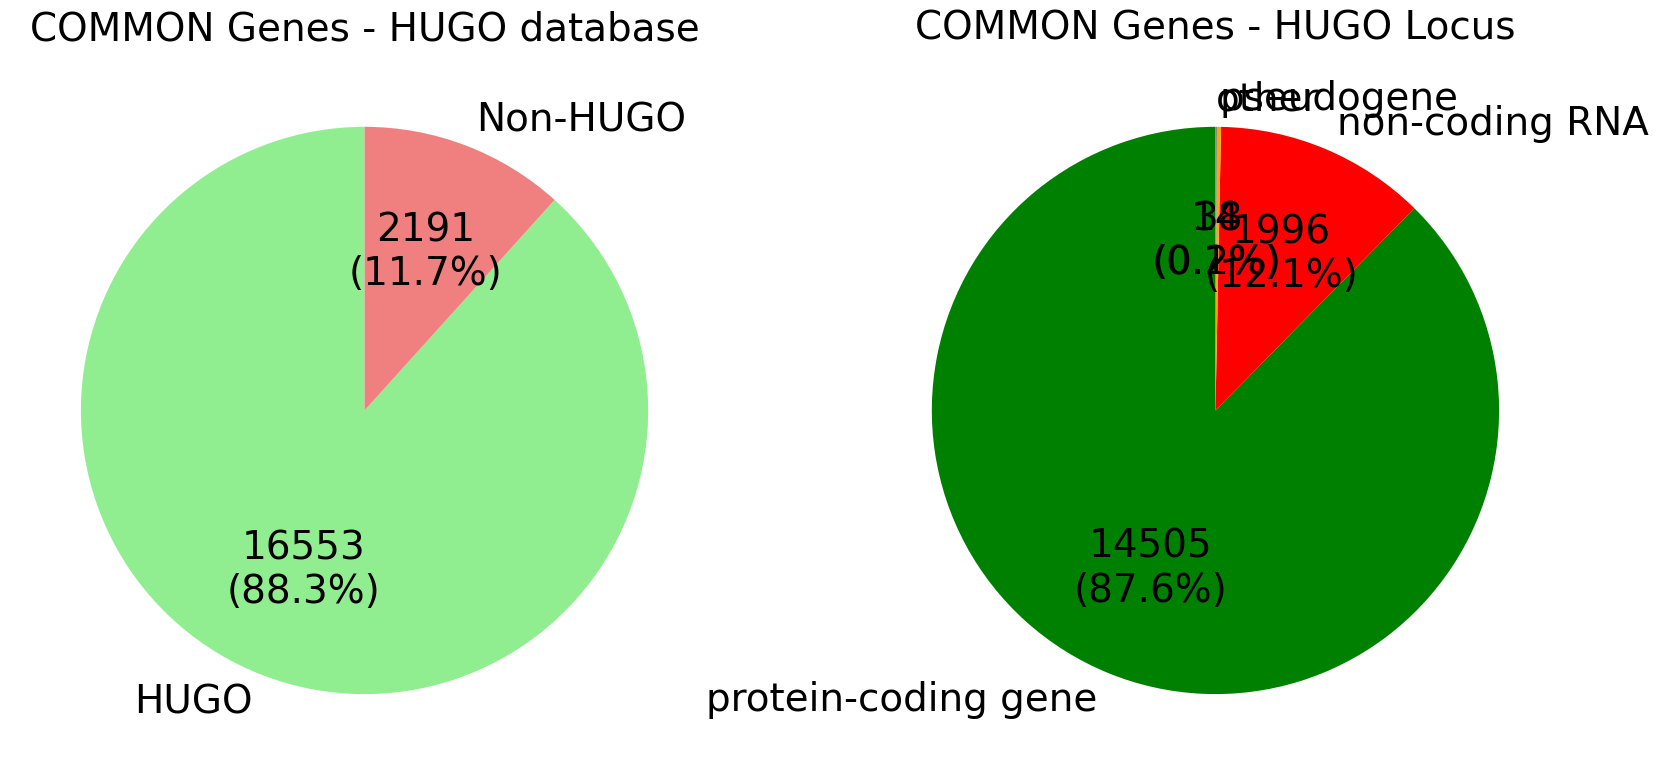

In [16]:
# General
labels_hugo = ['HUGO', 'Non-HUGO']
colors_hugo = ['lightgreen', 'lightcoral']
colors_locus = {'protein-coding gene': 'green', 
          'non-coding RNA': 'red', 
          'pseudogene': 'orange', 
          'other': 'grey'}

# Common
common_genes = genes_df[genes_df.all(axis=1)].index.tolist()
common_genes_hugo = list(set(list(common_genes)) & set(extHUGO_DF["ensembl_gene_id"].unique()))
common_genes_count = len(list(common_genes))
common_genes_hugo_percentage = (len(common_genes_hugo) / len(list(common_genes))) * 100
common_genes_sizes = [common_genes_hugo_percentage, 100 - common_genes_hugo_percentage]
common_genes_abs_sizes = [len(common_genes_hugo), common_genes_count - len(common_genes_hugo)]
common_locus_counts = extHUGO_DF_n[extHUGO_DF_n["ensembl_gene_id"].isin(common_genes_hugo)]["locus_group"].value_counts()


# Create a figure with 2x1 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

axs[0].pie(common_genes_sizes, labels=labels_hugo, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(common_genes_abs_sizes) / 100, p), 
        startangle=90, colors=colors_hugo)
axs[0].set_title("COMMON Genes - HUGO database")
axs[1].pie(common_locus_counts, labels=common_locus_counts.index,  autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(common_locus_counts) / 100, p),
           startangle=90, colors=[colors_locus[locus] for locus in common_locus_counts.index])
axs[1].set_title('COMMON Genes - HUGO Locus')

plt.show()

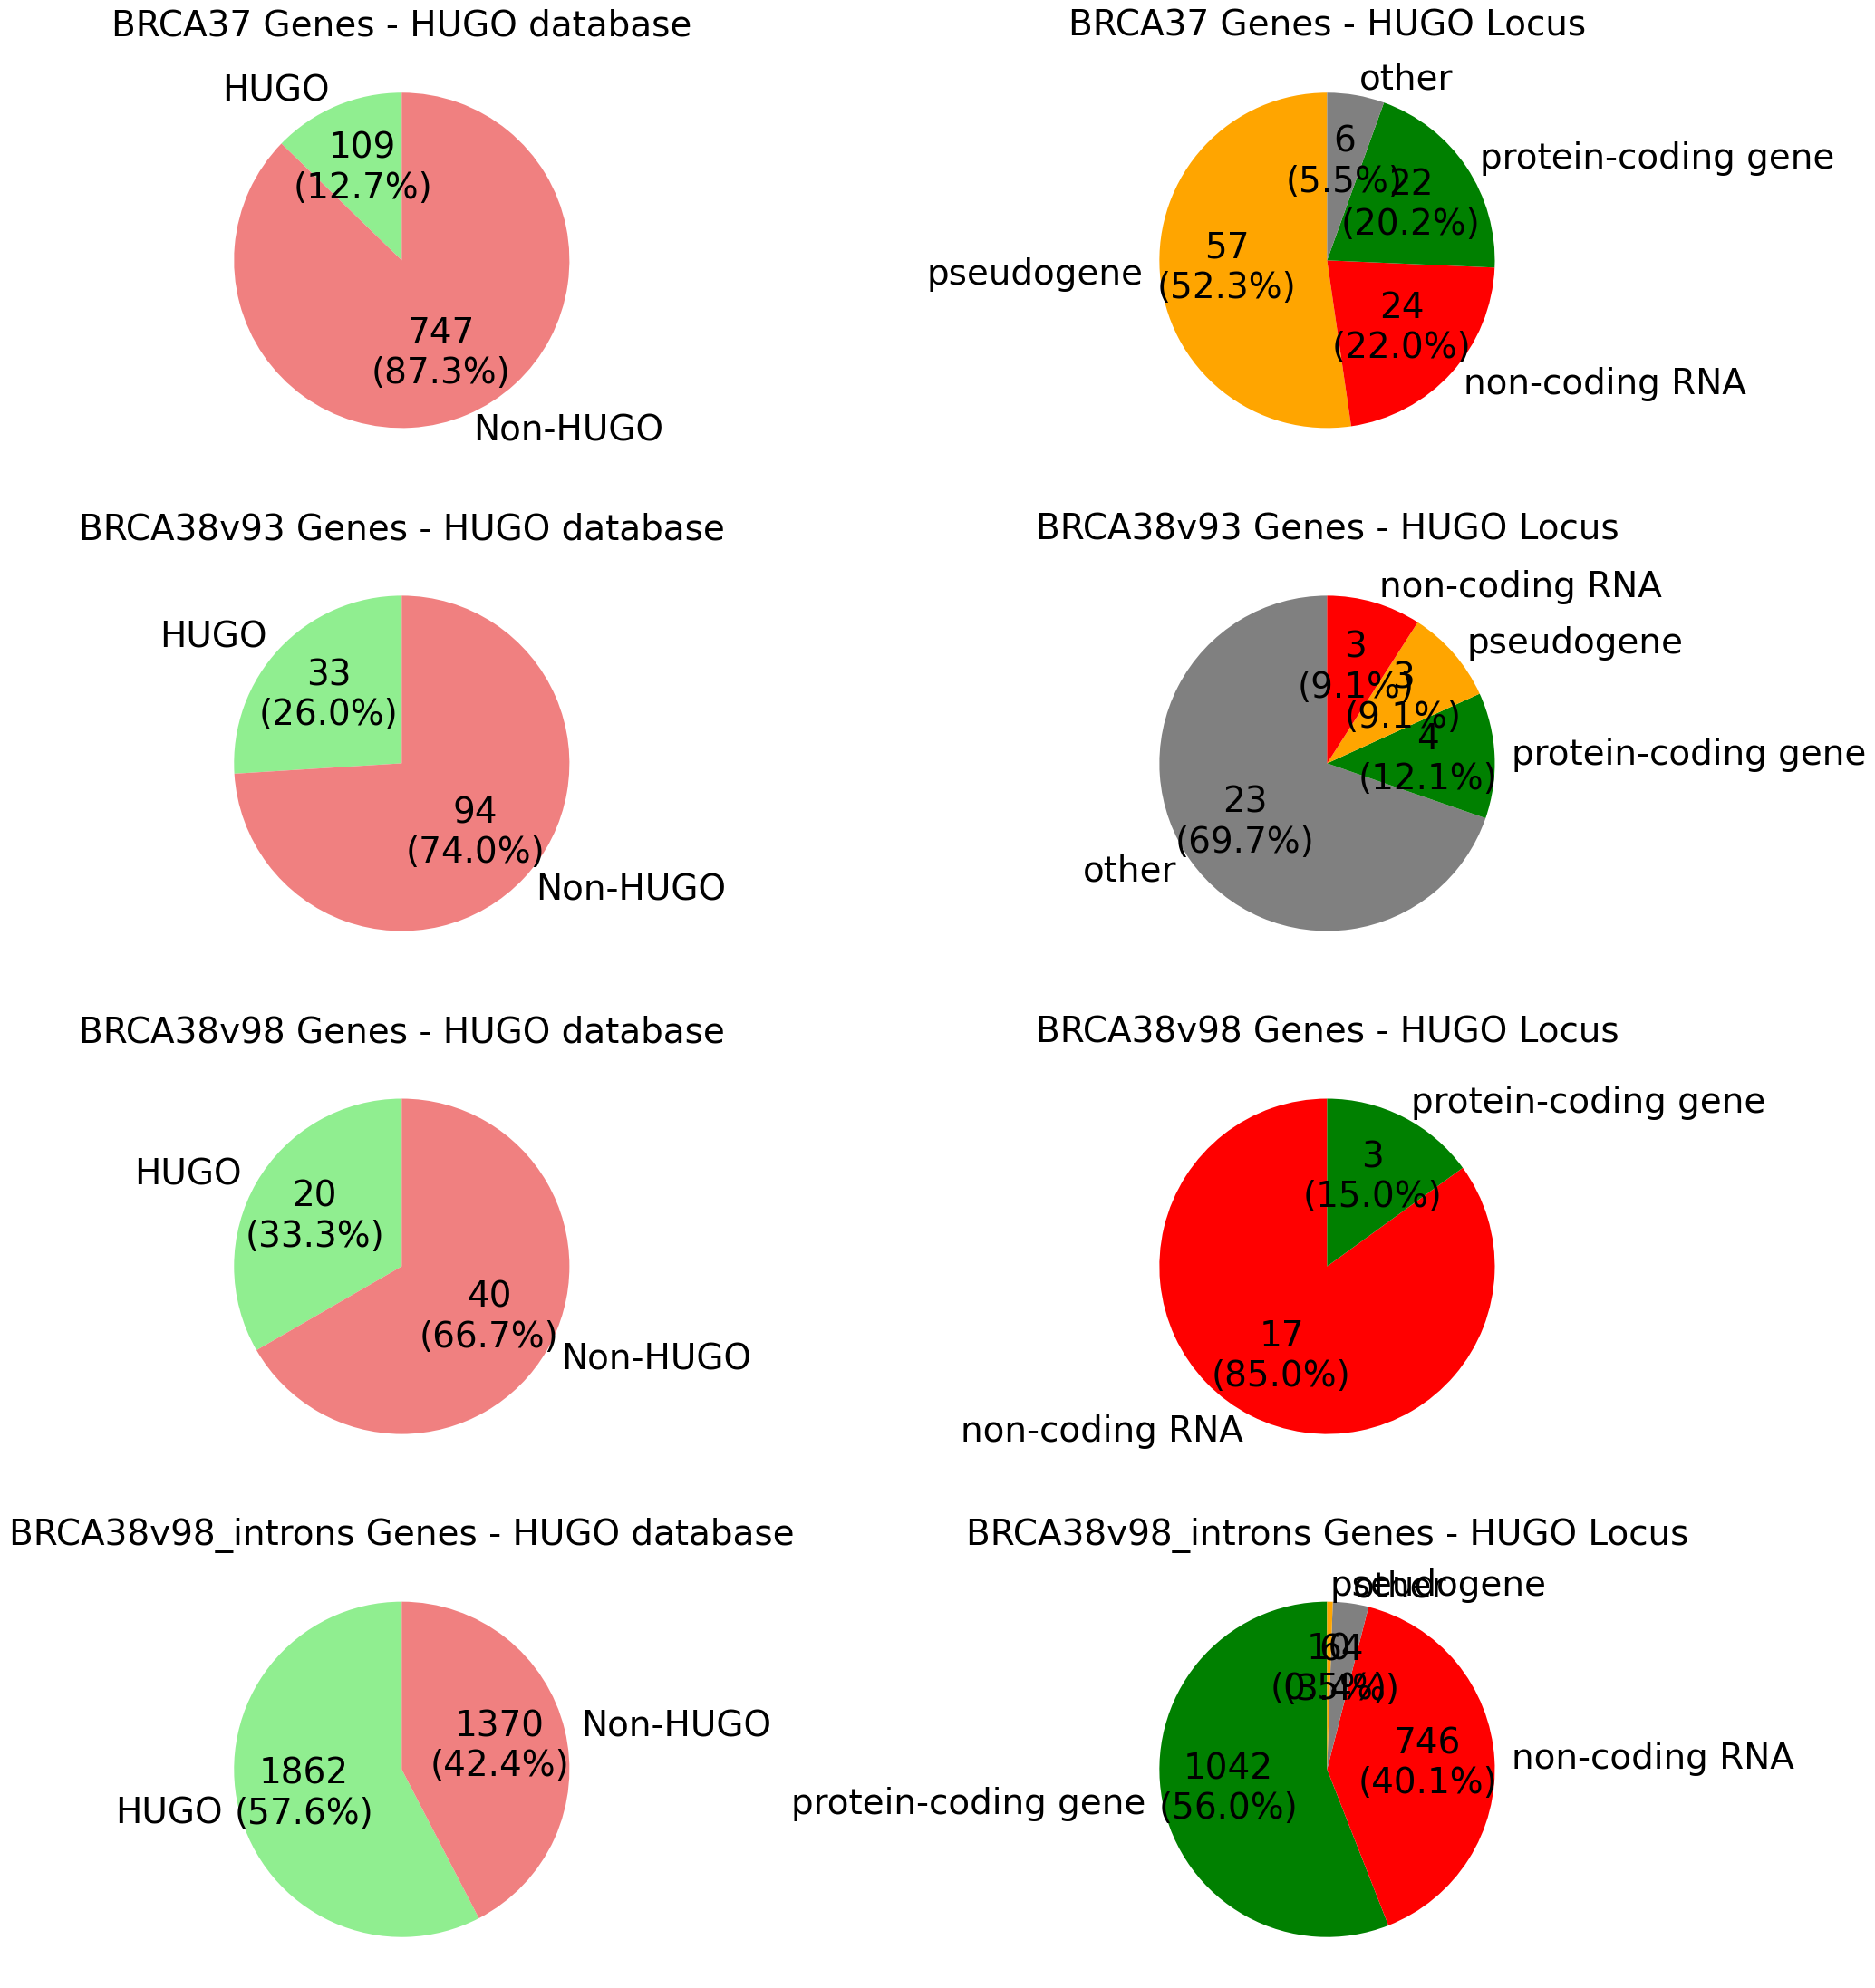

In [17]:
# Getting data ready
BRCA37_genes = genes_df[(genes_df['BRCA37'] == True) & (genes_df['BRCA38v93'] == False) & (genes_df['BRCA38v98'] == False) & (genes_df['BRCA38v98introns'] == False)].index.tolist()
BRCA37_genes_hugo = list(set(list(BRCA37_genes)) & set(extHUGO_DF["ensembl_gene_id"].unique()))
BRCA37_genes_count = len(list(BRCA37_genes))
BRCA37_genes_hugo_percentage = (len(BRCA37_genes_hugo) / len(list(BRCA37_genes))) * 100
BRCA37_genes_sizes = [BRCA37_genes_hugo_percentage, 100 - BRCA37_genes_hugo_percentage]
BRCA37_genes_abs_sizes = [len(BRCA37_genes_hugo), BRCA37_genes_count - len(BRCA37_genes_hugo)]
BRCA37_locus_counts = extHUGO_DF_n[extHUGO_DF_n["ensembl_gene_id"].isin(BRCA37_genes_hugo)]["locus_group"].value_counts()

BRCA38v93_genes = genes_df[(genes_df['BRCA37'] == False) & (genes_df['BRCA38v93'] == True) & (genes_df['BRCA38v98'] == False) & (genes_df['BRCA38v98introns'] == False)].index.tolist()
BRCA38v93_genes_hugo = list(set(list(BRCA38v93_genes)) & set(extHUGO_DF["ensembl_gene_id"].unique()))
BRCA38v93_genes_count = len(list(BRCA38v93_genes))
BRCA38v93_genes_hugo_percentage = (len(BRCA38v93_genes_hugo) / len(list(BRCA38v93_genes))) * 100
BRCA38v93_genes_sizes = [BRCA38v93_genes_hugo_percentage, 100 - BRCA38v93_genes_hugo_percentage]
BRCA38v93_genes_abs_sizes = [len(BRCA38v93_genes_hugo), BRCA38v93_genes_count - len(BRCA38v93_genes_hugo)]
BRCA38v93_locus_counts = extHUGO_DF_n[extHUGO_DF_n["ensembl_gene_id"].isin(BRCA38v93_genes_hugo)]["locus_group"].value_counts()

BRCA38v98_genes = genes_df[(genes_df['BRCA37'] == False) & (genes_df['BRCA38v93'] == False) & (genes_df['BRCA38v98'] == True) & (genes_df['BRCA38v98introns'] == False)].index.tolist()
BRCA38v98_genes_hugo = list(set(list(BRCA38v98_genes)) & set(extHUGO_DF["ensembl_gene_id"].unique()))
BRCA38v98_genes_count = len(list(BRCA38v98_genes))
BRCA38v98_genes_hugo_percentage = (len(BRCA38v98_genes_hugo) / len(list(BRCA38v98_genes))) * 100
BRCA38v98_genes_sizes = [BRCA38v98_genes_hugo_percentage, 100 - BRCA38v98_genes_hugo_percentage]
BRCA38v98_genes_abs_sizes = [len(BRCA38v98_genes_hugo), BRCA38v98_genes_count - len(BRCA38v98_genes_hugo)]
BRCA38v98_locus_counts = extHUGO_DF_n[extHUGO_DF_n["ensembl_gene_id"].isin(BRCA38v98_genes_hugo)]["locus_group"].value_counts()

BRCA38v98introns_genes = genes_df[(genes_df['BRCA37'] == False) & (genes_df['BRCA38v93'] == False) & (genes_df['BRCA38v98'] == False) & (genes_df['BRCA38v98introns'] == True)].index.tolist()
BRCA38v98introns_genes_hugo = list(set(list(BRCA38v98introns_genes)) & set(extHUGO_DF["ensembl_gene_id"].unique()))
BRCA38v98introns_genes_count = len(list(BRCA38v98introns_genes))
BRCA38v98introns_genes_hugo_percentage = (len(BRCA38v98introns_genes_hugo) / len(list(BRCA38v98introns_genes))) * 100
BRCA38v98introns_genes_sizes = [BRCA38v98introns_genes_hugo_percentage, 100 - BRCA38v98introns_genes_hugo_percentage]
BRCA38v98introns_genes_abs_sizes = [len(BRCA38v98introns_genes_hugo), BRCA38v98introns_genes_count - len(BRCA38v98introns_genes_hugo)]
BRCA38v98introns_locus_counts = extHUGO_DF_n[extHUGO_DF_n["ensembl_gene_id"].isin(BRCA38v98introns_genes_hugo)]["locus_group"].value_counts()


# Create a figure with 2x2 subplots
fig, axs = plt.subplots(4, 2, figsize=(12, 14))

axs[0, 0].pie(BRCA37_genes_sizes, labels=labels_hugo, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(BRCA37_genes_abs_sizes) / 100, p), 
              startangle=90, colors=colors_hugo)
axs[0, 0].set_title("BRCA37 Genes - HUGO database")
axs[0, 1].pie(BRCA37_locus_counts, labels=BRCA37_locus_counts.index,  autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(BRCA37_locus_counts) / 100, p),
           startangle=90, colors=[colors_locus[locus] for locus in BRCA37_locus_counts.index])
axs[0, 1].set_title('BRCA37 Genes - HUGO Locus')

axs[1, 0].pie(BRCA38v93_genes_sizes, labels=labels_hugo, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(BRCA38v93_genes_abs_sizes) / 100, p), 
              startangle=90, colors=colors_hugo)
axs[1, 0].set_title("BRCA38v93 Genes - HUGO database")
axs[1, 1].pie(BRCA38v93_locus_counts, labels=BRCA38v93_locus_counts.index,  autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(BRCA38v93_locus_counts) / 100, p),
           startangle=90, colors=[colors_locus[locus] for locus in BRCA38v93_locus_counts.index])
axs[1, 1].set_title("BRCA38v93 Genes - HUGO Locus")

axs[2, 0].pie(BRCA38v98_genes_sizes, labels=labels_hugo, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(BRCA38v98_genes_abs_sizes) / 100, p), 
              startangle=90, colors=colors_hugo)
axs[2, 0].set_title("BRCA38v98 Genes - HUGO database")
axs[2, 1].pie(BRCA38v98_locus_counts, labels=BRCA38v98_locus_counts.index,  autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(BRCA38v98_locus_counts) / 100, p),
           startangle=90, colors=[colors_locus[locus] for locus in BRCA38v98_locus_counts.index])
axs[2, 1].set_title("BRCA38v98 Genes - HUGO Locus")

axs[3, 0].pie(BRCA38v98introns_genes_sizes, labels=labels_hugo, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(BRCA38v98introns_genes_abs_sizes) / 100, p), 
              startangle=90, colors=colors_hugo)
axs[3, 0].set_title("BRCA38v98_introns Genes - HUGO database")
axs[3, 1].pie(BRCA38v98introns_locus_counts, labels=BRCA38v98introns_locus_counts.index,  autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(BRCA38v98introns_locus_counts) / 100, p),
           startangle=90, colors=[colors_locus[locus] for locus in BRCA38v98introns_locus_counts.index])
axs[3, 1].set_title("BRCA38v98_introns Genes - HUGO Locus")

plt.show()

### Gene expression metrics 

* Correlation coefficient (R)

Calculate the correlation coefficient between the two vectors
The correlation coefficient measures the strength and direction of a linear relationship between two variables.
Correlation coefficient close to 1 suggests a strong positive relationship.


* Mean Squared Residual (MSR)

MSR is a measure of the average squared difference between corresponding values in two sets.
If MSR is 0, it means that there is a perfect match between the two sets.

In [20]:
# Subset the AnnData object based on the valid HUGO genes
# Reorder the count matrix and gene names
print(len(common_genes_hugo))
common_genes_hugo = sorted(common_genes_hugo)

adata_BRCA37_sub = adata_BRCA37[:, common_genes_hugo].copy()
adata_BRCA38v93_sub = adata_BRCA38v93[:, common_genes_hugo].copy()
adata_BRCA38v98_sub = adata_BRCA38v98[:, common_genes_hugo].copy()
adata_BRCA38v98introns_sub = adata_BRCA38v98introns[:, common_genes_hugo].copy()

# Unfold the matrices into vectors
vec_BRCA37 = adata_BRCA37_sub.X.toarray().flatten()
vec_BRCA38v93 = adata_BRCA38v93_sub.X.toarray().flatten()
vec_BRCA38v98 = adata_BRCA38v98_sub.X.toarray().flatten()
vec_BRCA38v98introns = adata_BRCA38v98introns_sub.X.toarray().flatten()

16553


In [19]:
# At the library level

print("BRCA37 vs BRCA38v98")
R__BRCA37_BRCA38v98 = np.corrcoef(vec_BRCA38v98, vec_BRCA37)[0, 1]
print("R2=", R__BRCA37_BRCA38v98)
msr__BRCA37_BRCA38v98 = np.mean((vec_BRCA38v98 - vec_BRCA37) ** 2)
print("MSR=", msr__BRCA37_BRCA38v98)
# Filter vectors based on non-zero indices  in both vectors
non_zero_indices = np.logical_or(vec_BRCA38v98 != 0, vec_BRCA37 != 0)
vec_BRCA38v98_filtered = vec_BRCA38v98[non_zero_indices].copy()
vec_BRCA37_filtered = vec_BRCA37[non_zero_indices].copy()
Rfilt__BRCA37_BRCA38v98 = np.corrcoef(vec_BRCA38v98_filtered, vec_BRCA37_filtered)[0, 1]
print("R2filt=", Rfilt__BRCA37_BRCA38v98)
msrfilt__BRCA37_BRCA38v98 = np.mean((vec_BRCA38v98_filtered - vec_BRCA37_filtered) ** 2)
print("MSRfilt=", msrfilt__BRCA37_BRCA38v98)
print("")


print("BRCA38v93 vs BRCA38v98")
R__BRCA38v93_BRCA38v98 = np.corrcoef(vec_BRCA38v98, vec_BRCA38v93)[0, 1]
print("R2=", R__BRCA38v93_BRCA38v98)
msr__BRCA38v93_BRCA38v98 = np.mean((vec_BRCA38v98 - vec_BRCA38v93) ** 2)
print("MSR=", msr__BRCA38v93_BRCA38v98)
# Filter vectors based on non-zero indices  in both vectors
non_zero_indices = np.logical_or(vec_BRCA38v98 != 0, vec_BRCA38v93 != 0)
vec_BRCA38v98_filtered = vec_BRCA38v98[non_zero_indices].copy()
vec_BRCA38v93_filtered = vec_BRCA38v93[non_zero_indices].copy()
Rfilt__BRCA38v93_BRCA38v98 = np.corrcoef(vec_BRCA38v98_filtered, vec_BRCA38v93_filtered)[0, 1]
print("R2filt=", Rfilt__BRCA38v93_BRCA38v98)
msrfilt__BRCA38v93_BRCA38v98 = np.mean((vec_BRCA38v98_filtered - vec_BRCA38v93_filtered) ** 2)
print("MSRfilt=", msrfilt__BRCA38v93_BRCA38v98)
print("")


print("BRCA38v98_introns vs BRCA38v98")
R__BRCA38v98introns_BRCA38v98 = np.corrcoef(vec_BRCA38v98, vec_BRCA38v98introns)[0, 1]
print("R2=", R__BRCA38v98introns_BRCA38v98)
msr__BRCA38v98introns_BRCA38v98 = np.mean((vec_BRCA38v98 - vec_BRCA38v98introns) ** 2)
print("MSR=", msr__BRCA38v98introns_BRCA38v98)
# Filter vectors based on non-zero indices  in both vectors
non_zero_indices = np.logical_or(vec_BRCA38v98 != 0, vec_BRCA38v98introns != 0)
vec_BRCA38v98_filtered = vec_BRCA38v98[non_zero_indices].copy()
vec_BRCA38v98introns_filtered = vec_BRCA38v98introns[non_zero_indices].copy()
Rfilt__BRCA38v98introns_BRCA38v98 = np.corrcoef(vec_BRCA38v98_filtered, vec_BRCA38v98introns_filtered)[0, 1]
print("R2filt=", Rfilt__BRCA38v98introns_BRCA38v98)
msrfilt__BRCA38v98introns_BRCA38v98 = np.mean((vec_BRCA38v98_filtered - vec_BRCA38v98introns_filtered) ** 2)
print("MSRfilt=", msrfilt__BRCA38v98introns_BRCA38v98)

BRCA37 vs BRCA38v98
R2= 0.9972846892410554
MSR= 0.032510854
R2filt= 0.9969971304106556
MSRfilt= 0.38924494

BRCA38v93 vs BRCA38v98
R2= 0.9974114649005597
MSR= 0.030999301
R2filt= 0.9971386842042586
MSRfilt= 0.37254792

BRCA38v98_introns vs BRCA38v98
R2= 0.9909433230012545
MSR= 0.112611875
R2filt= 0.991341153575861
MSRfilt= 1.0689616


In [24]:
# At the gene level

geneexp_metrics_df = pd.DataFrame(adata_BRCA38v98_sub.var.gene_names)

# Calculate and add mean values
geneexp_metrics_df["mean_BRCA37"] = np.sum(adata_BRCA37_sub.X, axis=0).tolist()[0]
geneexp_metrics_df["mean_BRCA38v93"] = np.sum(adata_BRCA38v93_sub.X, axis=0).tolist()[0]
geneexp_metrics_df["mean_BRCA38v98"] = np.sum(adata_BRCA38v98_sub.X, axis=0).tolist()[0]
geneexp_metrics_df["mean_BRCA38v98_introns"] = np.sum(adata_BRCA38v98introns_sub.X, axis=0).tolist()[0]

# Calculate and add square root results
geneexp_metrics_df["mr__BRCA37_BRCA38v98"] = np.sqrt(np.mean((adata_BRCA37_sub.X.toarray() - adata_BRCA38v98_sub.X.toarray()) ** 2, axis=0))
geneexp_metrics_df["mr__BRCA38v93_BRCA38v98"] = np.sqrt(np.mean((adata_BRCA38v93_sub.X.toarray() - adata_BRCA38v98_sub.X.toarray()) ** 2, axis=0))
geneexp_metrics_df["mr__BRCA38v98introns_BRCA38v98"] = np.sqrt(np.mean((adata_BRCA38v98introns_sub.X.toarray() - adata_BRCA38v98_sub.X.toarray()) ** 2, axis=0))

# Calculate and add percentage difference results
geneexp_metrics_df["mrp__BRCA37_BRCA38v98"] = ((np.sum(adata_BRCA38v98_sub.X, axis=0) - np.sum(adata_BRCA37_sub.X, axis=0)) / 
                                                    abs(np.sum(adata_BRCA37_sub.X, axis=0)) * 100).tolist()[0]
geneexp_metrics_df["mrp__BRCA38v93_BRCA38v98"] = ((np.sum(adata_BRCA38v98_sub.X, axis=0) - np.sum(adata_BRCA38v93_sub.X, axis=0)) / 
                                                    abs(np.sum(adata_BRCA38v93_sub.X, axis=0)) * 100).tolist()[0]
geneexp_metrics_df["mrp__BRCA38v98introns_BRCA38v98"] = ((np.sum(adata_BRCA38v98_sub.X, axis=0) - np.sum(adata_BRCA38v98introns_sub.X, axis=0)) / 
                                                    abs(np.sum(adata_BRCA38v98introns_sub.X, axis=0)) * 100).tolist()[0]

geneexp_metrics_df.head()
#msrfilt_bygene_df.sort_values(by='mrp__BRCA37_BRCA38v98', inplace=True, ascending=False)
#msrfilt_bygene_df.head()

,gene_names,mean_BRCA37,mean_BRCA38v93,mean_BRCA38v98,mean_BRCA38v98_introns,mr__BRCA37_BRCA38v98,mr__BRCA38v93_BRCA38v98,mr__BRCA38v98introns_BRCA38v98,mrp__BRCA37_BRCA38v98,mrp__BRCA38v93_BRCA38v98,mrp__BRCA38v98introns_BRCA38v98
gene_ids,,,,,,,,,,,
ENSG00000000003,TSPAN6,10.0,10.0,10.0,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000000419,DPM1,375.0,375.0,375.0,790.0,0.000000,0.000000,0.281938,0.000000,0.000000,-52.531648
ENSG00000000457,SCYL3,272.0,272.0,272.0,332.0,0.000000,0.000000,0.099784,0.000000,0.000000,-18.072289
ENSG00000000460,C1orf112,135.0,135.0,135.0,705.0,0.000000,0.000000,0.357927,0.000000,0.000000,-80.851066
ENSG00000000938,FGR,3170.0,3170.0,3166.0,6064.0,0.025764,0.025764,1.479027,-0.126183,-0.126183,-47.790238


## Considering genes expressed in >=5 cells

In [35]:
sc.pp.filter_genes(adata_BRCA37, min_cells=5, inplace=True)
sc.pp.filter_genes(adata_BRCA38v93, min_cells=5, inplace=True)
sc.pp.filter_genes(adata_BRCA38v98, min_cells=5, inplace=True)
sc.pp.filter_genes(adata_BRCA38v98introns, min_cells=5, inplace=True)

In [36]:
# Step 1: Identify genes with expression greater than 0 in at least one cell
# Step 2: Subset the count matrix based on identified genes

adata_BRCA37_genes = adata_BRCA37.X.sum(axis=0) > 0
adata_BRCA37_genes = list(adata_BRCA37[:, adata_BRCA37_genes.A1].var.gene_ids)
print(len(adata_BRCA37_genes))

adata_BRCA38v93_genes = adata_BRCA38v93.X.sum(axis=0) > 0
adata_BRCA38v93_genes = list(adata_BRCA38v93[:, adata_BRCA38v93_genes.A1].var.gene_ids)
print(len(adata_BRCA38v93_genes))

adata_BRCA38v98_genes = adata_BRCA38v98.X.sum(axis=0) > 0
adata_BRCA38v98_genes = list(adata_BRCA38v98[:, adata_BRCA38v98_genes.A1].var.gene_ids)
print(len(adata_BRCA38v98_genes))

adata_BRCA38v98introns_genes = adata_BRCA38v98introns.X.sum(axis=0) > 0
adata_BRCA38v98introns_genes = list(adata_BRCA38v98introns[:, adata_BRCA38v98introns_genes.A1].var.gene_ids)
print(len(adata_BRCA38v98introns_genes))

# Setting index back
adata_BRCA37.var_names = adata_BRCA37.var.gene_ids
adata_BRCA38v93.var_names = adata_BRCA38v93.var.gene_ids
adata_BRCA38v98.var_names = adata_BRCA38v98.var.gene_ids
adata_BRCA38v98introns.var_names = adata_BRCA38v98introns.var.gene_ids

15764
16001
16885
19301


### Gene distribution

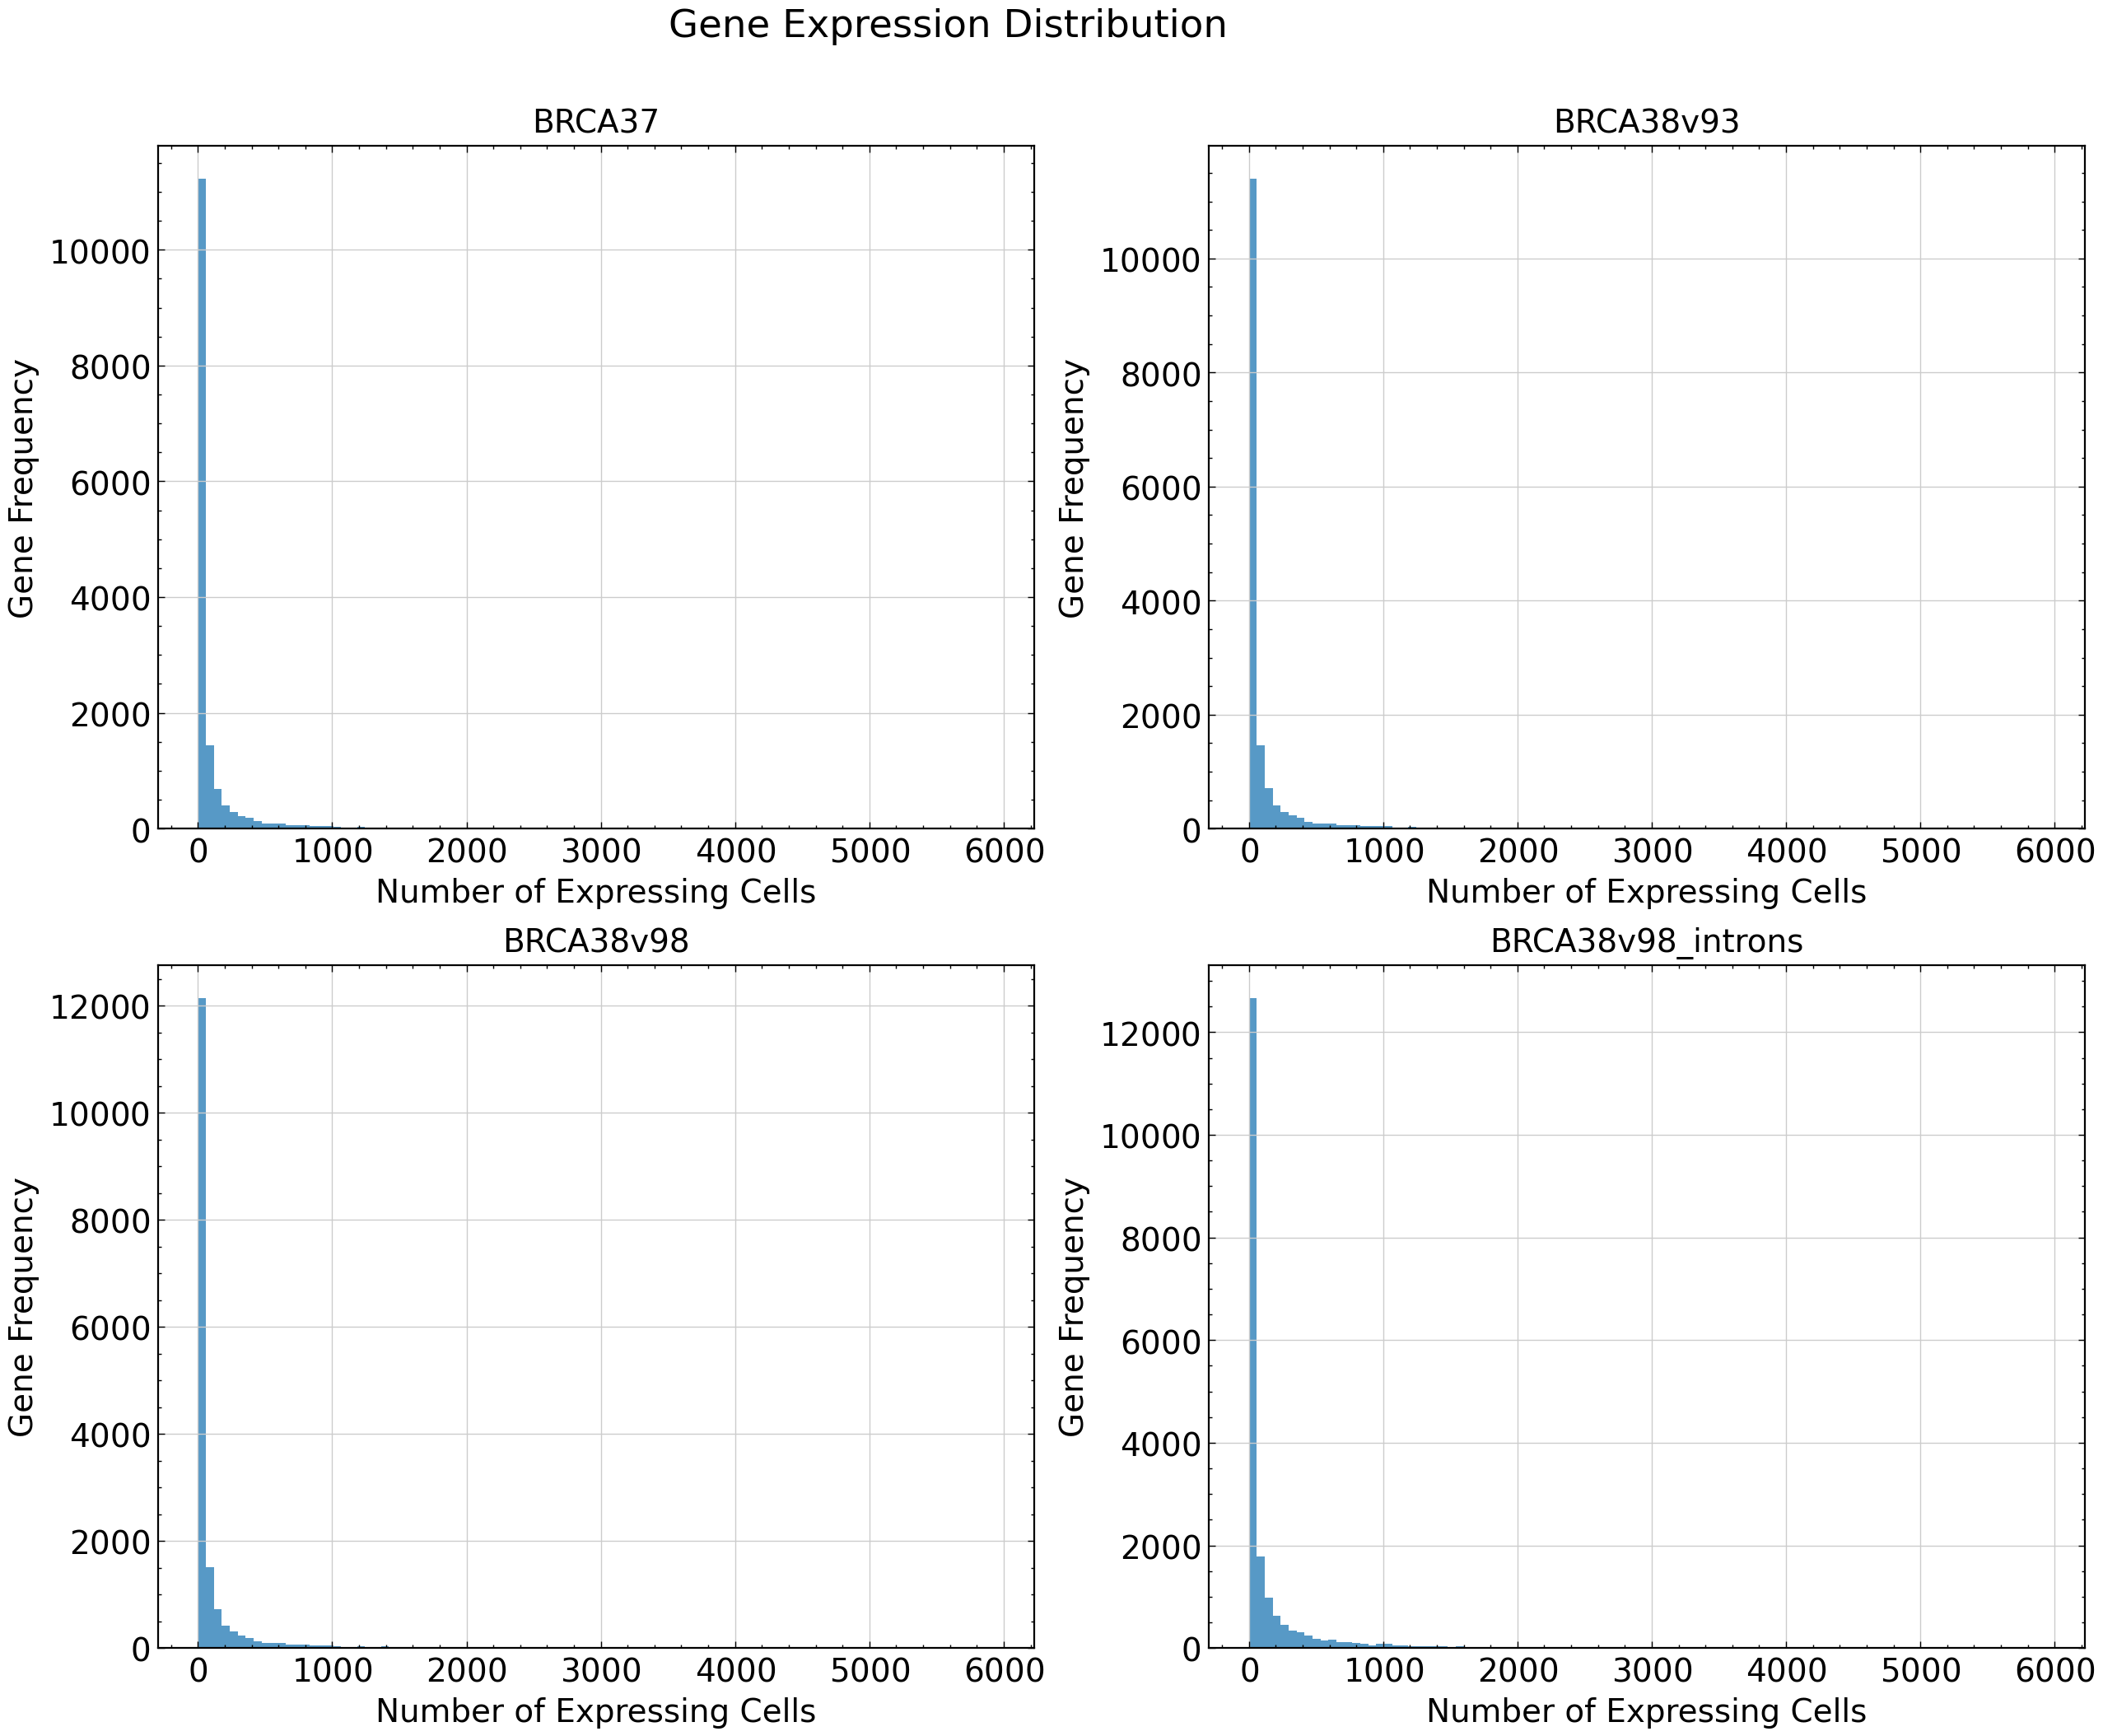

In [37]:
# Getting data ready
n_cells_BRCA37 = np.sum(adata_BRCA37.X > 1, axis=0)
n_cells_df_BRCA37 = np.ravel(n_cells_BRCA37)

n_cells_BRCA38v93 = np.sum(adata_BRCA38v93.X > 1, axis=0)
n_cells_df_BRCA38v93 = np.ravel(n_cells_BRCA38v93)

n_cells_BRCA38v98 = np.sum(adata_BRCA38v98.X > 1, axis=0)
n_cells_df_BRCA38v98 = np.ravel(n_cells_BRCA38v98)

n_cells_BRCA38v98introns = np.sum(adata_BRCA38v98introns.X > 1, axis=0)
n_cells_df_BRCA38v98introns = np.ravel(n_cells_BRCA38v98introns)


# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Gene Expression Distribution")

axs[0, 0].hist(n_cells_df_BRCA37, bins=100, alpha=0.75)
axs[0, 0].set_xlabel('Number of Expressing Cells')
axs[0, 0].set_ylabel('Gene Frequency')
axs[0, 0].set_title("BRCA37")

axs[0, 1].hist(n_cells_df_BRCA38v93, bins=100, alpha=0.75)
axs[0, 1].set_xlabel('Number of Expressing Cells')
axs[0, 1].set_ylabel('Gene Frequency')
axs[0, 1].set_title("BRCA38v93")

axs[1, 0].hist(n_cells_df_BRCA38v98, bins=100, alpha=0.75)
axs[1, 0].set_xlabel('Number of Expressing Cells')
axs[1, 0].set_ylabel('Gene Frequency')
axs[1, 0].set_title("BRCA38v98")

axs[1, 1].hist(n_cells_df_BRCA38v98introns, bins=100, alpha=0.75)
axs[1, 1].set_xlabel('Number of Expressing Cells')
axs[1, 1].set_ylabel('Gene Frequency')
axs[1, 1].set_title("BRCA38v98_introns")

plt.show()

### Comparison of gene overlapping

In [38]:
# Create sets of UNIQUE gene names
adata_BRCA37_genes = set(adata_BRCA37_genes)
adata_BRCA38v93_genes = set(adata_BRCA38v93_genes)
adata_BRCA38v98_genes = set(adata_BRCA38v98_genes)
adata_BRCA38v98introns_genes = set(adata_BRCA38v98introns_genes)


# Get the union of gene names
all_genes = adata_BRCA37_genes.union(adata_BRCA38v93_genes, adata_BRCA38v98_genes, adata_BRCA38v98introns_genes)

# Create a DataFrame with default values as False
genes_df = pd.DataFrame(index=list(all_genes), columns=['BRCA37', 'BRCA38v93', 'BRCA38v98', 'BRCA38v98introns'], data=False)

# Update values based on the presence of genes in the BRCA37 and BRCA38 sets
genes_df['BRCA37'] = genes_df.index.isin(adata_BRCA37_genes)
genes_df['BRCA38v93'] = genes_df.index.isin(adata_BRCA38v93_genes)
genes_df['BRCA38v98'] = genes_df.index.isin(adata_BRCA38v98_genes)
genes_df['BRCA38v98introns'] = genes_df.index.isin(adata_BRCA38v98introns_genes)
genes_df['genes'] = genes_df.index
genes_df.reset_index(drop=True, inplace=True)
genes_df = genes_df.set_index('genes')
genes_df = genes_df.sort_values(by='genes')
genes_df.head()

,BRCA37,BRCA38v93,BRCA38v98,BRCA38v98introns
genes,,,,
ENSG00000000003,True,True,True,True
ENSG00000000419,True,True,True,True
ENSG00000000457,True,True,True,True
ENSG00000000460,True,True,True,True
ENSG00000000938,True,True,True,True


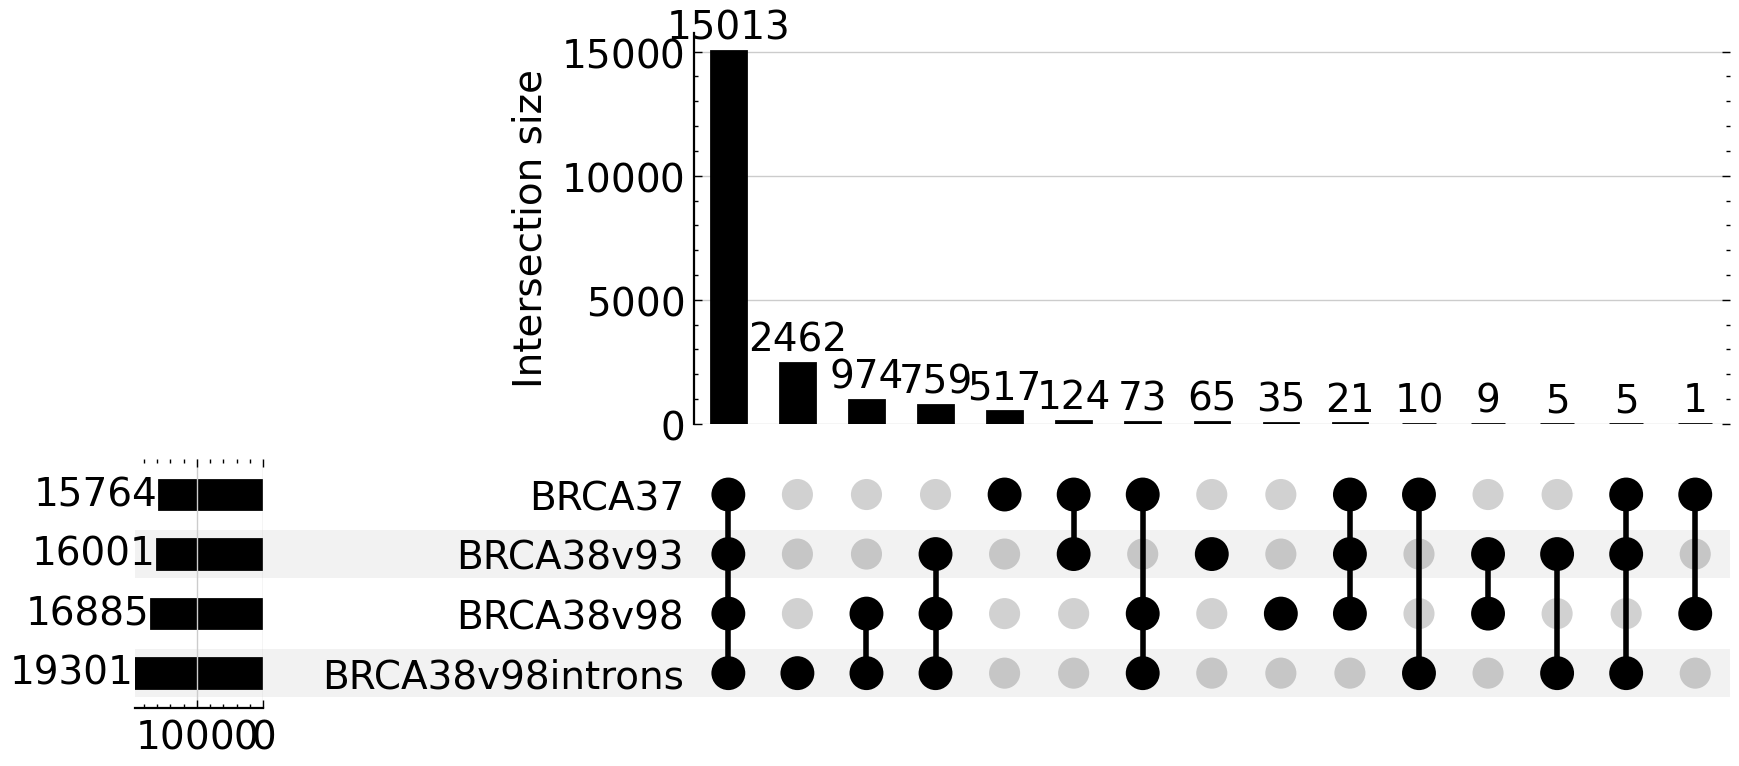

In [39]:
# Reset the index and drop 'genes' column before creating UpSet plot
genes_df_indicators = genes_df.reset_index(drop=True)

# this produces the same result as from_memberships above
genes_by_refver = from_indicators(genes_df_indicators, data=genes_df)

upset = UpSet(from_indicators(['BRCA37', 'BRCA38v93', 'BRCA38v98', 'BRCA38v98introns'], data=genes_by_refver), 
              show_counts=True, sort_by = "cardinality", sort_categories_by='cardinality')
upset.plot()
plt.show()

### Comparison with HUGO database

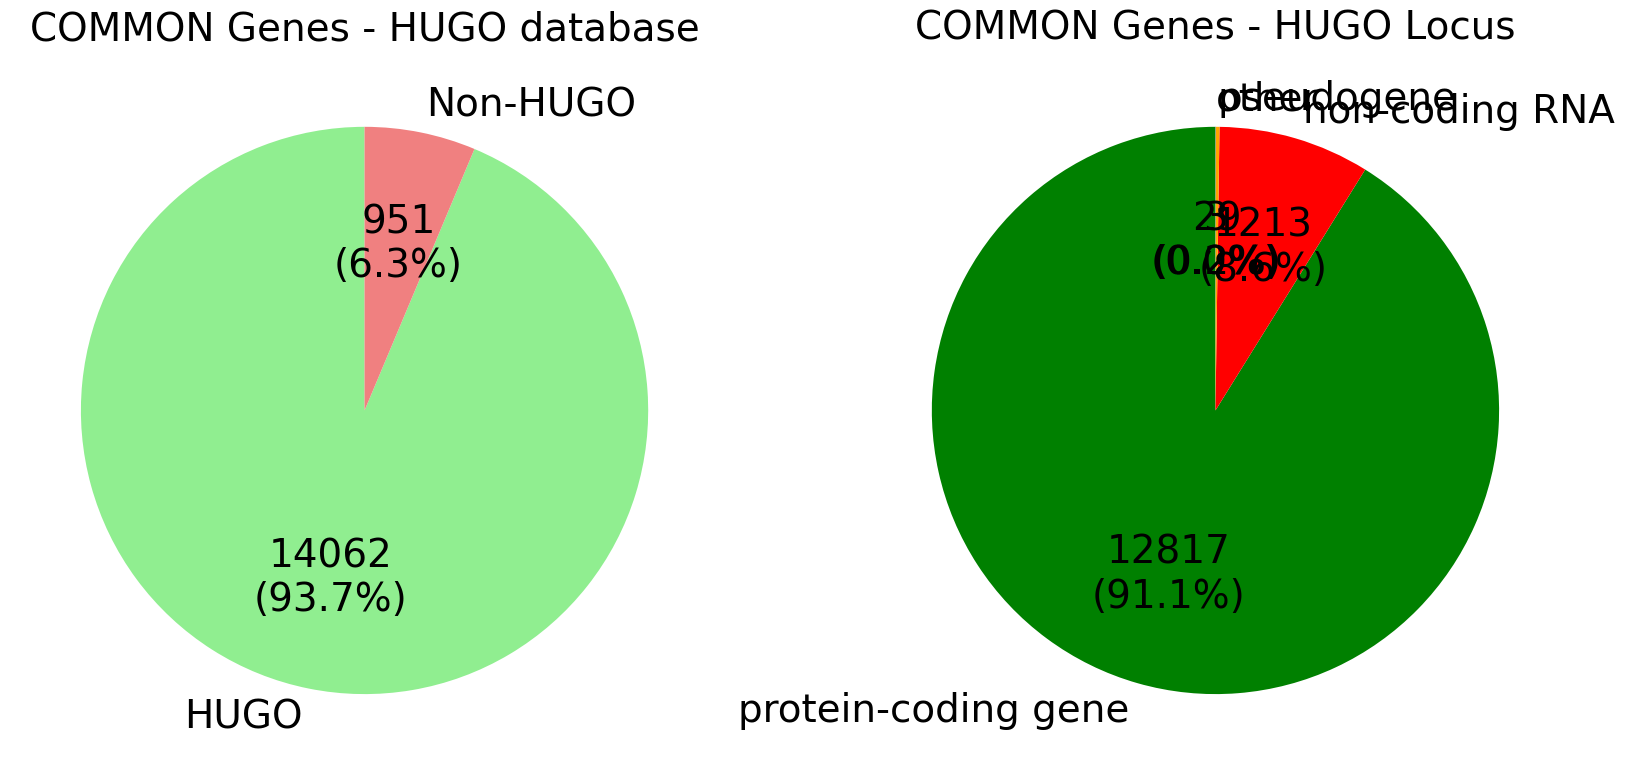

In [40]:
# General
labels_hugo = ['HUGO', 'Non-HUGO']
colors_hugo = ['lightgreen', 'lightcoral']
colors_locus = {'protein-coding gene': 'green', 
          'non-coding RNA': 'red', 
          'pseudogene': 'orange', 
          'other': 'grey'}

# Common
common_genes = genes_df[genes_df.all(axis=1)].index.tolist()
common_genes_hugo = list(set(list(common_genes)) & set(extHUGO_DF["ensembl_gene_id"].unique()))
common_genes_count = len(list(common_genes))
common_genes_hugo_percentage = (len(common_genes_hugo) / len(list(common_genes))) * 100
common_genes_sizes = [common_genes_hugo_percentage, 100 - common_genes_hugo_percentage]
common_genes_abs_sizes = [len(common_genes_hugo), common_genes_count - len(common_genes_hugo)]
common_locus_counts = extHUGO_DF_n[extHUGO_DF_n["ensembl_gene_id"].isin(common_genes_hugo)]["locus_group"].value_counts()


# Create a figure with 2x1 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

axs[0].pie(common_genes_sizes, labels=labels_hugo, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(common_genes_abs_sizes) / 100, p), 
        startangle=90, colors=colors_hugo)
axs[0].set_title("COMMON Genes - HUGO database")
axs[1].pie(common_locus_counts, labels=common_locus_counts.index,  autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(common_locus_counts) / 100, p),
           startangle=90, colors=[colors_locus[locus] for locus in common_locus_counts.index])
axs[1].set_title('COMMON Genes - HUGO Locus')

plt.show()

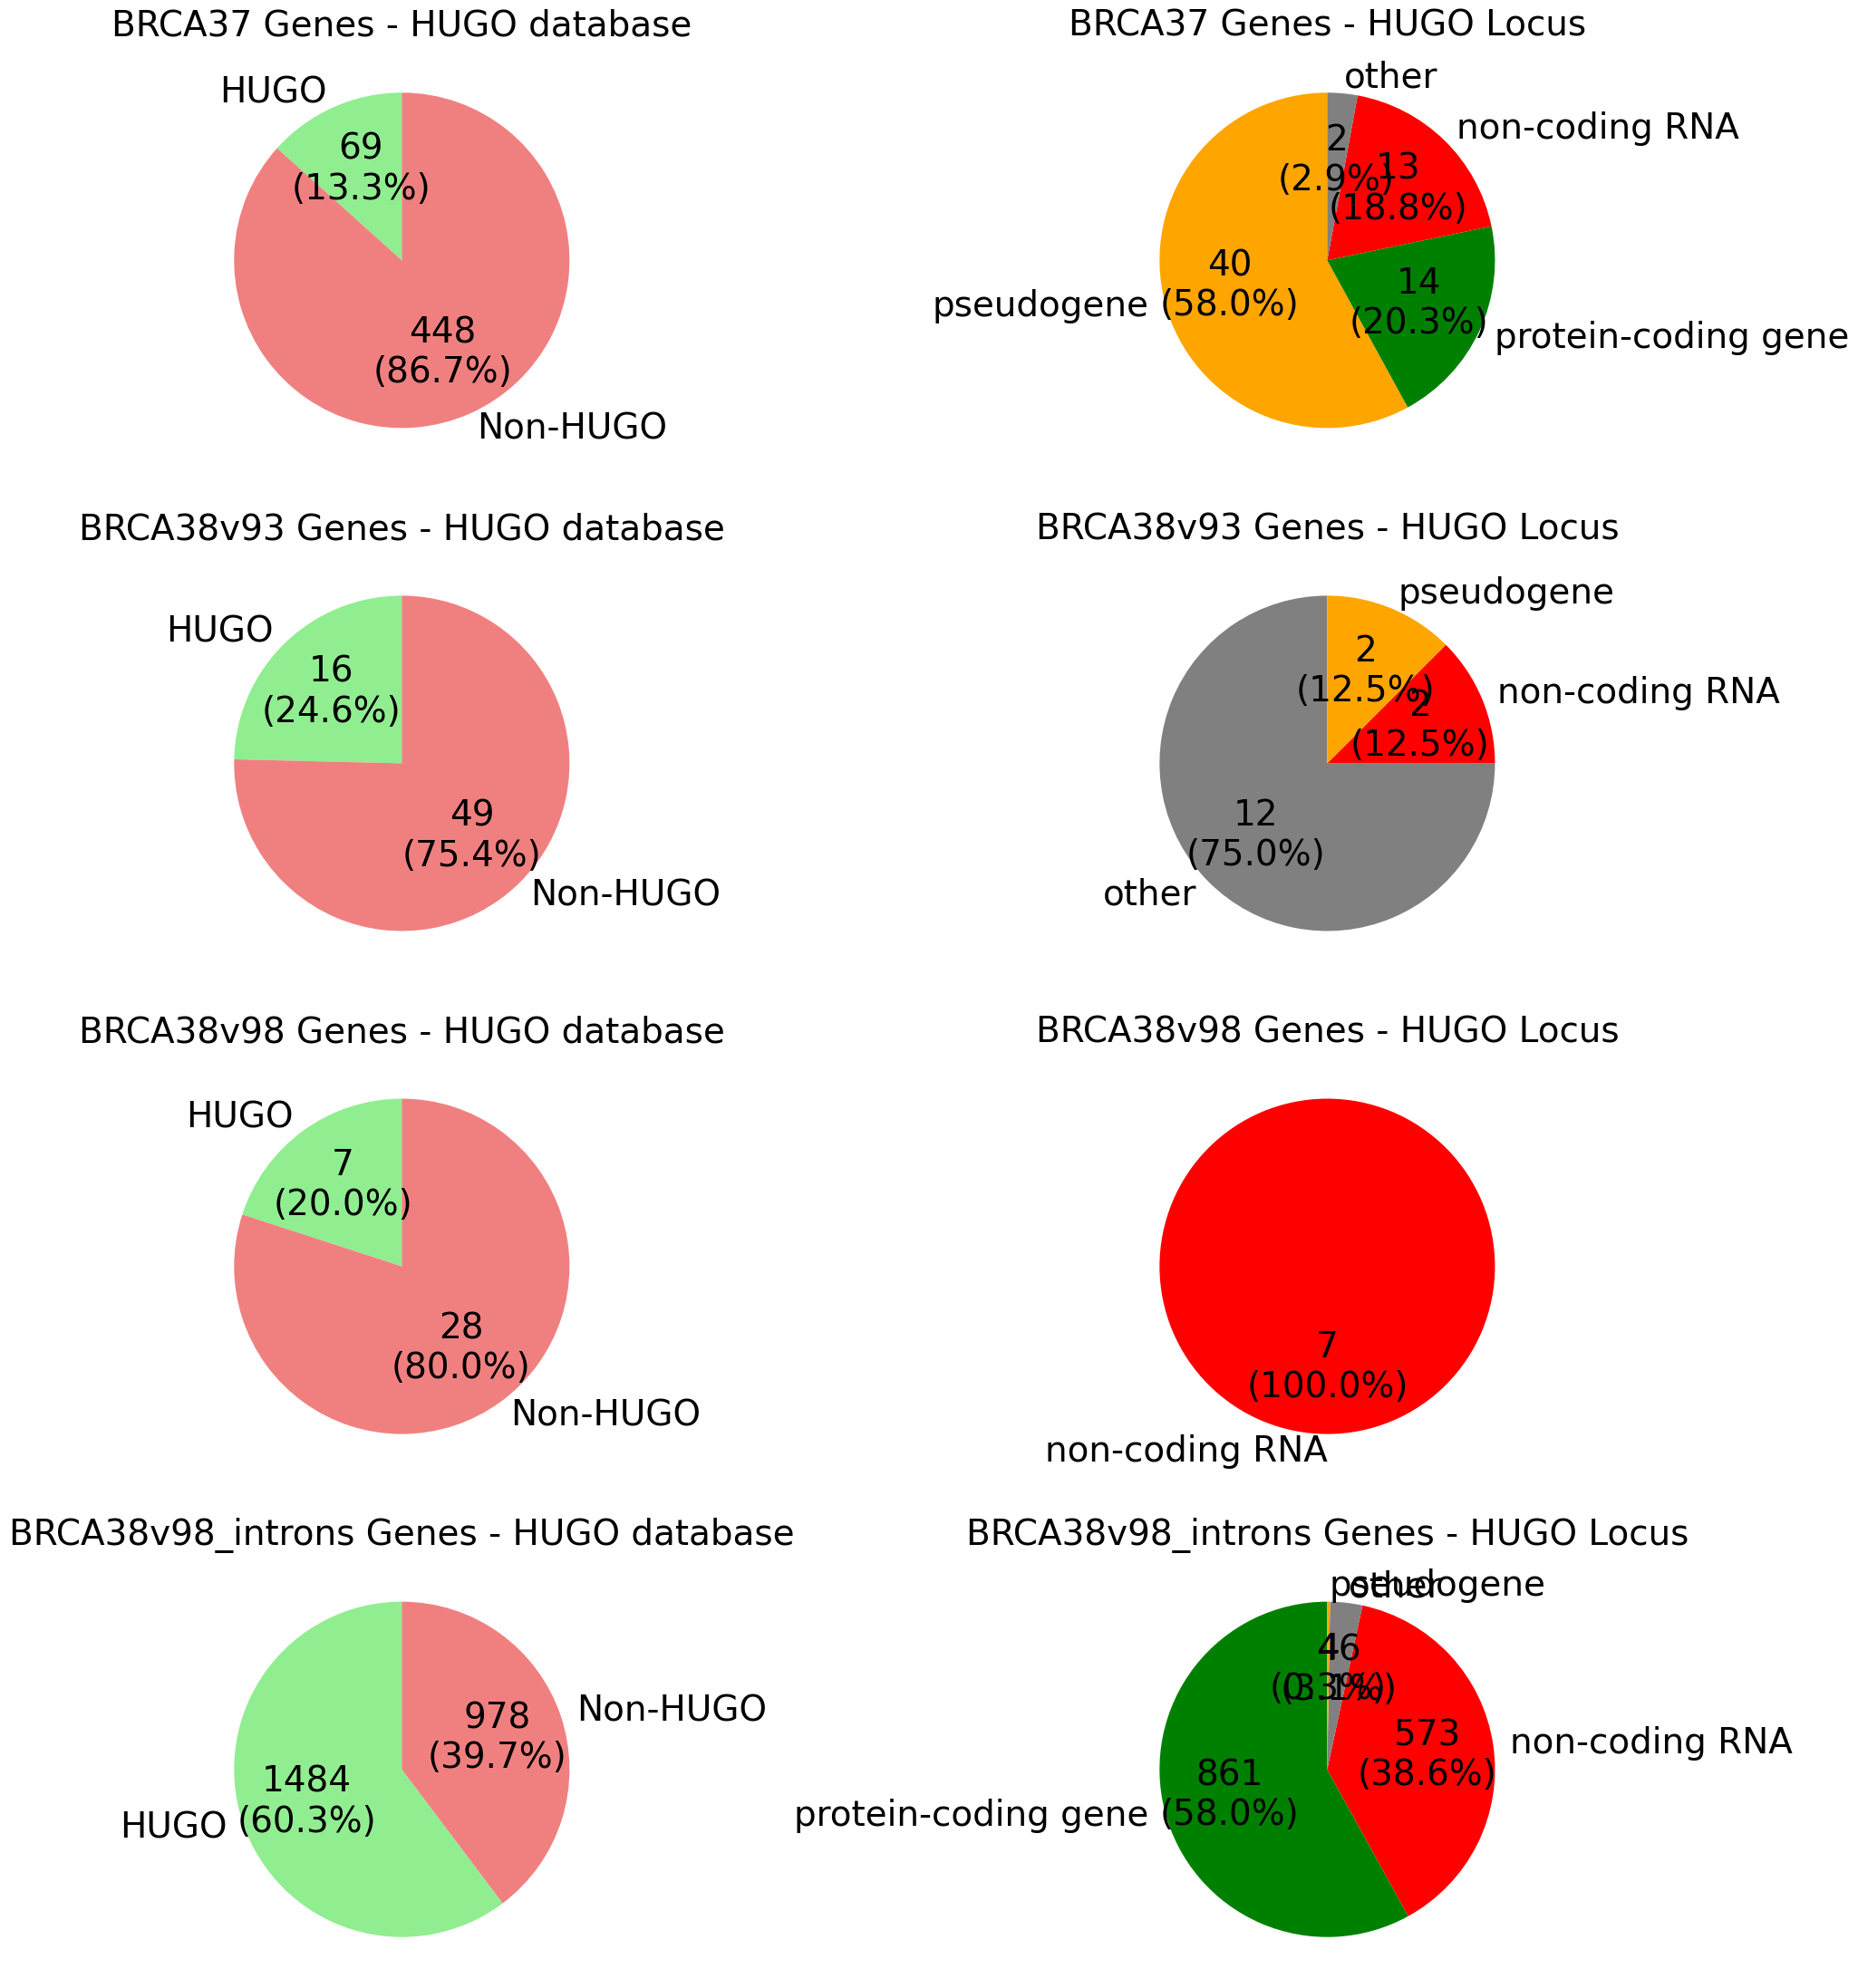

In [41]:
# Getting data ready
BRCA37_genes = genes_df[(genes_df['BRCA37'] == True) & (genes_df['BRCA38v93'] == False) & (genes_df['BRCA38v98'] == False) & (genes_df['BRCA38v98introns'] == False)].index.tolist()
BRCA37_genes_hugo = list(set(list(BRCA37_genes)) & set(extHUGO_DF["ensembl_gene_id"].unique()))
BRCA37_genes_count = len(list(BRCA37_genes))
BRCA37_genes_hugo_percentage = (len(BRCA37_genes_hugo) / len(list(BRCA37_genes))) * 100
BRCA37_genes_sizes = [BRCA37_genes_hugo_percentage, 100 - BRCA37_genes_hugo_percentage]
BRCA37_genes_abs_sizes = [len(BRCA37_genes_hugo), BRCA37_genes_count - len(BRCA37_genes_hugo)]
BRCA37_locus_counts = extHUGO_DF_n[extHUGO_DF_n["ensembl_gene_id"].isin(BRCA37_genes_hugo)]["locus_group"].value_counts()

BRCA38v93_genes = genes_df[(genes_df['BRCA37'] == False) & (genes_df['BRCA38v93'] == True) & (genes_df['BRCA38v98'] == False) & (genes_df['BRCA38v98introns'] == False)].index.tolist()
BRCA38v93_genes_hugo = list(set(list(BRCA38v93_genes)) & set(extHUGO_DF["ensembl_gene_id"].unique()))
BRCA38v93_genes_count = len(list(BRCA38v93_genes))
BRCA38v93_genes_hugo_percentage = (len(BRCA38v93_genes_hugo) / len(list(BRCA38v93_genes))) * 100
BRCA38v93_genes_sizes = [BRCA38v93_genes_hugo_percentage, 100 - BRCA38v93_genes_hugo_percentage]
BRCA38v93_genes_abs_sizes = [len(BRCA38v93_genes_hugo), BRCA38v93_genes_count - len(BRCA38v93_genes_hugo)]
BRCA38v93_locus_counts = extHUGO_DF_n[extHUGO_DF_n["ensembl_gene_id"].isin(BRCA38v93_genes_hugo)]["locus_group"].value_counts()

BRCA38v98_genes = genes_df[(genes_df['BRCA37'] == False) & (genes_df['BRCA38v93'] == False) & (genes_df['BRCA38v98'] == True) & (genes_df['BRCA38v98introns'] == False)].index.tolist()
BRCA38v98_genes_hugo = list(set(list(BRCA38v98_genes)) & set(extHUGO_DF["ensembl_gene_id"].unique()))
BRCA38v98_genes_count = len(list(BRCA38v98_genes))
BRCA38v98_genes_hugo_percentage = (len(BRCA38v98_genes_hugo) / len(list(BRCA38v98_genes))) * 100
BRCA38v98_genes_sizes = [BRCA38v98_genes_hugo_percentage, 100 - BRCA38v98_genes_hugo_percentage]
BRCA38v98_genes_abs_sizes = [len(BRCA38v98_genes_hugo), BRCA38v98_genes_count - len(BRCA38v98_genes_hugo)]
BRCA38v98_locus_counts = extHUGO_DF_n[extHUGO_DF_n["ensembl_gene_id"].isin(BRCA38v98_genes_hugo)]["locus_group"].value_counts()

BRCA38v98introns_genes = genes_df[(genes_df['BRCA37'] == False) & (genes_df['BRCA38v93'] == False) & (genes_df['BRCA38v98'] == False) & (genes_df['BRCA38v98introns'] == True)].index.tolist()
BRCA38v98introns_genes_hugo = list(set(list(BRCA38v98introns_genes)) & set(extHUGO_DF["ensembl_gene_id"].unique()))
BRCA38v98introns_genes_count = len(list(BRCA38v98introns_genes))
BRCA38v98introns_genes_hugo_percentage = (len(BRCA38v98introns_genes_hugo) / len(list(BRCA38v98introns_genes))) * 100
BRCA38v98introns_genes_sizes = [BRCA38v98introns_genes_hugo_percentage, 100 - BRCA38v98introns_genes_hugo_percentage]
BRCA38v98introns_genes_abs_sizes = [len(BRCA38v98introns_genes_hugo), BRCA38v98introns_genes_count - len(BRCA38v98introns_genes_hugo)]
BRCA38v98introns_locus_counts = extHUGO_DF_n[extHUGO_DF_n["ensembl_gene_id"].isin(BRCA38v98introns_genes_hugo)]["locus_group"].value_counts()


# Create a figure with 2x2 subplots
fig, axs = plt.subplots(4, 2, figsize=(12, 14))

axs[0, 0].pie(BRCA37_genes_sizes, labels=labels_hugo, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(BRCA37_genes_abs_sizes) / 100, p), 
              startangle=90, colors=colors_hugo)
axs[0, 0].set_title("BRCA37 Genes - HUGO database")
axs[0, 1].pie(BRCA37_locus_counts, labels=BRCA37_locus_counts.index,  autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(BRCA37_locus_counts) / 100, p),
           startangle=90, colors=[colors_locus[locus] for locus in BRCA37_locus_counts.index])
axs[0, 1].set_title('BRCA37 Genes - HUGO Locus')

axs[1, 0].pie(BRCA38v93_genes_sizes, labels=labels_hugo, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(BRCA38v93_genes_abs_sizes) / 100, p), 
              startangle=90, colors=colors_hugo)
axs[1, 0].set_title("BRCA38v93 Genes - HUGO database")
axs[1, 1].pie(BRCA38v93_locus_counts, labels=BRCA38v93_locus_counts.index,  autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(BRCA38v93_locus_counts) / 100, p),
           startangle=90, colors=[colors_locus[locus] for locus in BRCA38v93_locus_counts.index])
axs[1, 1].set_title("BRCA38v93 Genes - HUGO Locus")

axs[2, 0].pie(BRCA38v98_genes_sizes, labels=labels_hugo, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(BRCA38v98_genes_abs_sizes) / 100, p), 
              startangle=90, colors=colors_hugo)
axs[2, 0].set_title("BRCA38v98 Genes - HUGO database")
axs[2, 1].pie(BRCA38v98_locus_counts, labels=BRCA38v98_locus_counts.index,  autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(BRCA38v98_locus_counts) / 100, p),
           startangle=90, colors=[colors_locus[locus] for locus in BRCA38v98_locus_counts.index])
axs[2, 1].set_title("BRCA38v98 Genes - HUGO Locus")

axs[3, 0].pie(BRCA38v98introns_genes_sizes, labels=labels_hugo, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(BRCA38v98introns_genes_abs_sizes) / 100, p), 
              startangle=90, colors=colors_hugo)
axs[3, 0].set_title("BRCA38v98_introns Genes - HUGO database")
axs[3, 1].pie(BRCA38v98introns_locus_counts, labels=BRCA38v98introns_locus_counts.index,  autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(BRCA38v98introns_locus_counts) / 100, p),
           startangle=90, colors=[colors_locus[locus] for locus in BRCA38v98introns_locus_counts.index])
axs[3, 1].set_title("BRCA38v98_introns Genes - HUGO Locus")

plt.show()

### Gene expression metrics 

* Correlation coefficient (R)

Calculate the correlation coefficient between the two vectors
The correlation coefficient measures the strength and direction of a linear relationship between two variables.
Correlation coefficient close to 1 suggests a strong positive relationship.


* Mean Squared Residual (MSR)

MSR is a measure of the average squared difference between corresponding values in two sets.
If MSR is 0, it means that there is a perfect match between the two sets.

In [42]:
# Subset the AnnData object based on the valid HUGO genes
# Reorder the count matrix and gene names
print(len(common_genes_hugo))
common_genes_hugo = sorted(common_genes_hugo)

adata_BRCA37_sub = adata_BRCA37[:, common_genes_hugo].copy()
adata_BRCA38v93_sub = adata_BRCA38v93[:, common_genes_hugo].copy()
adata_BRCA38v98_sub = adata_BRCA38v98[:, common_genes_hugo].copy()
adata_BRCA38v98introns_sub = adata_BRCA38v98introns[:, common_genes_hugo].copy()

# Unfold the matrices into vectors
vec_BRCA37 = adata_BRCA37_sub.X.toarray().flatten()
vec_BRCA38v93 = adata_BRCA38v93_sub.X.toarray().flatten()
vec_BRCA38v98 = adata_BRCA38v98_sub.X.toarray().flatten()
vec_BRCA38v98introns = adata_BRCA38v98introns_sub.X.toarray().flatten()

14062


In [43]:
# At the library level

print("BRCA37 vs BRCA38v98")
R__BRCA37_BRCA38v98 = np.corrcoef(vec_BRCA38v98, vec_BRCA37)[0, 1]
print("R2=", R__BRCA37_BRCA38v98)
msr__BRCA37_BRCA38v98 = np.mean((vec_BRCA38v98 - vec_BRCA37) ** 2)
print("MSR=", msr__BRCA37_BRCA38v98)
# Filter vectors based on non-zero indices  in both vectors
non_zero_indices = np.logical_or(vec_BRCA38v98 != 0, vec_BRCA37 != 0)
vec_BRCA38v98_filtered = vec_BRCA38v98[non_zero_indices].copy()
vec_BRCA37_filtered = vec_BRCA37[non_zero_indices].copy()
Rfilt__BRCA37_BRCA38v98 = np.corrcoef(vec_BRCA38v98_filtered, vec_BRCA37_filtered)[0, 1]
print("R2filt=", Rfilt__BRCA37_BRCA38v98)
msrfilt__BRCA37_BRCA38v98 = np.mean((vec_BRCA38v98_filtered - vec_BRCA37_filtered) ** 2)
print("MSRfilt=", msrfilt__BRCA37_BRCA38v98)
print("")


print("BRCA38v93 vs BRCA38v98")
R__BRCA38v93_BRCA38v98 = np.corrcoef(vec_BRCA38v98, vec_BRCA38v93)[0, 1]
print("R2=", R__BRCA38v93_BRCA38v98)
msr__BRCA38v93_BRCA38v98 = np.mean((vec_BRCA38v98 - vec_BRCA38v93) ** 2)
print("MSR=", msr__BRCA38v93_BRCA38v98)
# Filter vectors based on non-zero indices  in both vectors
non_zero_indices = np.logical_or(vec_BRCA38v98 != 0, vec_BRCA38v93 != 0)
vec_BRCA38v98_filtered = vec_BRCA38v98[non_zero_indices].copy()
vec_BRCA38v93_filtered = vec_BRCA38v93[non_zero_indices].copy()
Rfilt__BRCA38v93_BRCA38v98 = np.corrcoef(vec_BRCA38v98_filtered, vec_BRCA38v93_filtered)[0, 1]
print("R2filt=", Rfilt__BRCA38v93_BRCA38v98)
msrfilt__BRCA38v93_BRCA38v98 = np.mean((vec_BRCA38v98_filtered - vec_BRCA38v93_filtered) ** 2)
print("MSRfilt=", msrfilt__BRCA38v93_BRCA38v98)
print("")


print("BRCA38v98_introns vs BRCA38v98")
R__BRCA38v98introns_BRCA38v98 = np.corrcoef(vec_BRCA38v98, vec_BRCA38v98introns)[0, 1]
print("R2=", R__BRCA38v98introns_BRCA38v98)
msr__BRCA38v98introns_BRCA38v98 = np.mean((vec_BRCA38v98 - vec_BRCA38v98introns) ** 2)
print("MSR=", msr__BRCA38v98introns_BRCA38v98)
# Filter vectors based on non-zero indices  in both vectors
non_zero_indices = np.logical_or(vec_BRCA38v98 != 0, vec_BRCA38v98introns != 0)
vec_BRCA38v98_filtered = vec_BRCA38v98[non_zero_indices].copy()
vec_BRCA38v98introns_filtered = vec_BRCA38v98introns[non_zero_indices].copy()
Rfilt__BRCA38v98introns_BRCA38v98 = np.corrcoef(vec_BRCA38v98_filtered, vec_BRCA38v98introns_filtered)[0, 1]
print("R2filt=", Rfilt__BRCA38v98introns_BRCA38v98)
msrfilt__BRCA38v98introns_BRCA38v98 = np.mean((vec_BRCA38v98_filtered - vec_BRCA38v98introns_filtered) ** 2)
print("MSRfilt=", msrfilt__BRCA38v98introns_BRCA38v98)

BRCA37 vs BRCA38v98
R2= 0.9972868886428471
MSR= 0.038179386
R2filt= 0.9970037907619462
MSRfilt= 0.38883236

BRCA38v93 vs BRCA38v98
R2= 0.9974110982870186
MSR= 0.036439355
R2filt= 0.9971423431006426
MSRfilt= 0.37247577

BRCA38v98_introns vs BRCA38v98
R2= 0.9909829713157239
MSR= 0.13203004
R2filt= 0.9913648215014105
MSRfilt= 1.0680118


In [44]:
# At the gene level

geneexp_metrics_df = pd.DataFrame(adata_BRCA38v98_sub.var.gene_names)

# Calculate and add mean values
geneexp_metrics_df["mean_BRCA37"] = np.sum(adata_BRCA37_sub.X, axis=0).tolist()[0]
geneexp_metrics_df["mean_BRCA38v93"] = np.sum(adata_BRCA38v93_sub.X, axis=0).tolist()[0]
geneexp_metrics_df["mean_BRCA38v98"] = np.sum(adata_BRCA38v98_sub.X, axis=0).tolist()[0]
geneexp_metrics_df["mean_BRCA38v98_introns"] = np.sum(adata_BRCA38v98introns_sub.X, axis=0).tolist()[0]

# Calculate and add square root results
geneexp_metrics_df["mr__BRCA37_BRCA38v98"] = np.sqrt(np.mean((adata_BRCA37_sub.X.toarray() - adata_BRCA38v98_sub.X.toarray()) ** 2, axis=0))
geneexp_metrics_df["mr__BRCA38v93_BRCA38v98"] = np.sqrt(np.mean((adata_BRCA38v93_sub.X.toarray() - adata_BRCA38v98_sub.X.toarray()) ** 2, axis=0))
geneexp_metrics_df["mr__BRCA38v98introns_BRCA38v98"] = np.sqrt(np.mean((adata_BRCA38v98introns_sub.X.toarray() - adata_BRCA38v98_sub.X.toarray()) ** 2, axis=0))

# Calculate and add percentage difference results
geneexp_metrics_df["mrp__BRCA37_BRCA38v98"] = ((np.sum(adata_BRCA38v98_sub.X, axis=0) - np.sum(adata_BRCA37_sub.X, axis=0)) / 
                                                    abs(np.sum(adata_BRCA37_sub.X, axis=0)) * 100).tolist()[0]
geneexp_metrics_df["mrp__BRCA38v93_BRCA38v98"] = ((np.sum(adata_BRCA38v98_sub.X, axis=0) - np.sum(adata_BRCA38v93_sub.X, axis=0)) / 
                                                    abs(np.sum(adata_BRCA38v93_sub.X, axis=0)) * 100).tolist()[0]
geneexp_metrics_df["mrp__BRCA38v98introns_BRCA38v98"] = ((np.sum(adata_BRCA38v98_sub.X, axis=0) - np.sum(adata_BRCA38v98introns_sub.X, axis=0)) / 
                                                    abs(np.sum(adata_BRCA38v98introns_sub.X, axis=0)) * 100).tolist()[0]

geneexp_metrics_df.head()
#msrfilt_bygene_df.sort_values(by='mrp__BRCA37_BRCA38v98', inplace=True, ascending=False)
#msrfilt_bygene_df.head()

,gene_names,mean_BRCA37,mean_BRCA38v93,mean_BRCA38v98,mean_BRCA38v98_introns,mr__BRCA37_BRCA38v98,mr__BRCA38v93_BRCA38v98,mr__BRCA38v98introns_BRCA38v98,mrp__BRCA37_BRCA38v98,mrp__BRCA38v93_BRCA38v98,mrp__BRCA38v98introns_BRCA38v98
gene_ids,,,,,,,,,,,
ENSG00000000003,ENSG00000000003,10.0,10.0,10.0,10.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000000419,ENSG00000000419,375.0,375.0,375.0,790.0,0.000000,0.000000,0.281938,0.000000,0.000000,-52.531648
ENSG00000000457,ENSG00000000457,272.0,272.0,272.0,332.0,0.000000,0.000000,0.099784,0.000000,0.000000,-18.072289
ENSG00000000460,ENSG00000000460,135.0,135.0,135.0,705.0,0.000000,0.000000,0.357927,0.000000,0.000000,-80.851066
ENSG00000000938,ENSG00000000938,3170.0,3170.0,3166.0,6064.0,0.025764,0.025764,1.479027,-0.126183,-0.126183,-47.790238
